# Movie Rating Prediction Model

## Khám phá dữ liệu phục vụ cho việc tiền xử lý

### Import các thư viện

In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split

### Load vào dữ liệu thô sau khi đã được crawl

In [2]:
file_path = "../data/raw/IMDB_movies_final.csv"
df = pd.read_csv(file_path)

### Thông tin cơ bản

Dữ liệu sau khi load được lưu vào biến `df`. Để có cái nhìn bao quát về cấu trúc và đặc điểm của dataset, nhóm hiển thị 5 dòng đầu và 5 dòng cuối của dữ liệu như sau 

In [3]:
# Hiển thị 5 dòng đầu
df.head()

,rank,title,genres,budget,release_year,run_time,mpa,metascore,vote_count,rating
0,1,Frankenstein,"Drama, Fantasy, Horror, Sci-Fi","$120,000,000 (estimated)",2025.0,2h 29m,R,77.0,(132K),7.6
1,2,One Battle After Another,"Action, Crime, Drama, Thriller","$130,000,000 (estimated)",2025.0,2h 41m,R,95.0,(163K),8.0
2,3,The Running Man,"Action, Adventure, Sci-Fi, Thriller","$110,000,000 (estimated)",2025.0,2h 13m,R,56.0,(17K),6.7
3,4,Predator: Badlands,"Action, Adventure, Sci-Fi, Thriller","$105,000,000 (estimated)",2025.0,1h 47m,PG-13,71.0,(38K),7.5
4,5,Playdate,"Action, Comedy","$17,525",2025.0,1h 33m,PG-13,20.0,(10K),5.5


In [4]:
# Hiển thị 5 dòng cuối
df.tail()

,rank,title,genres,budget,release_year,run_time,mpa,metascore,vote_count,rating
10043,10046,Return of the Living Dead III,Horror,"$2,000,000 (estimated)",1993.0,1h 37m,NaN,47.0,(18K),5.9
10044,10047,Sweetness,Thriller,NaN,2025.0,1h 33m,NaN,NaN,(81),6.8
10045,10048,Dark Harvest,"Fantasy, Horror",NaN,2023.0,1h 36m,R,51.0,(10K),5.5
10046,10049,Across the River and Into the Trees,"Drama, Romance, War",NaN,2022.0,1h 46m,NaN,63.0,(1K),6.6
10047,10050,Below,"Action, Horror, Mystery, Thriller","$40,000,000 (estimated)",2002.0,1h 45m,R,55.0,(26K),6.1


Và số dòng, số cột của dataset

In [5]:
num_rows, num_columns = df.shape
print(f"Số dòng: {num_rows}")
print(f"Số cột: {num_columns}")

Số dòng: 10048
Số cột: 10


Dữ liệu bao gồm 10048 số lượng record và 10 đặc trưng, ý nghĩa của mỗi dòng dữ liệu phản ánh các thông tin chi tiết cho mỗi bộ phim trên nền tảng IMDb qua các đặc điểm như là xếp hạng phim, tiêu đề, thể loại, kinh phí, năm phát hành, thời lượng bộ phim, MPA, điểm metascore, số lượng bình chọn và điểm rating. 

Kích thước của bộ dữ liệu có độ lớn tương đối, có ý nghĩa đối với các phân tích xu hướng, và mô hình hóa dự đoán cho điểm rating. 

### Tính toàn vẹn dữ liệu (Data integrity)

Để kiểm tra bộ dataset có bị trùng lặp (duplicated) hay không, nhóm sử dụng phương thức `duplicated()` trong `Pandas` để phát hiện các dòng trùng lặp.

In [6]:
duplicate_rows = df[df.duplicated()]
num_duplicates = df.duplicated().sum()

print(f"Số lượng dòng trùng lặp hoàn toàn: {num_duplicates}")

if num_duplicates > 0:
    print("Các dòng trùng lặp:")
    print(duplicate_rows)

Số lượng dòng trùng lặp hoàn toàn: 0


Nhóm còn kiểm tra có dòng nào trong bộ dataset mà không chứa bất kỳ thông tin nào hay không qua phương thức `isnull()` trong `Pandas`. 

In [7]:
empty_rows_count = df.isnull().all(axis=1).sum()

if empty_rows_count > 0:
    print(f"Có {empty_rows_count} dòng hoàn toàn trống")
else:
    print("Tất cả các dòng đều có ít nhất một dữ liệu (không có dòng không chứa bất kỳ thông tin nào)")

Tất cả các dòng đều có ít nhất một dữ liệu (không có dòng không chứa bất kỳ thông tin nào)


Nhóm kết luận bộ dataset đảm bảo được tính toàn vẹn về dữ liệu.

### Tính chính xác dữ liệu (Data validation)

Nhóm tiến hành kiểm tra xem giá trị của các cột dữ liệu nào có bất hợp lý hay không, cụ thể như sau: 

- Điểm `rating` phải nằm trong đoạn từ 0 đến 10. 

In [8]:
invalid_rating = df[(df['rating'] < 0) | (df['rating'] > 10)]
if len(invalid_rating) > 0:
    print(f"Có {len(invalid_rating)} dòng có điểm rating bất hợp lý (ngoài 0-10), gồm:")
    print(invalid_rating[['title', 'rating']])
else:
    print("Giá trị của đặc trưng rating hợp lệ")

Giá trị của đặc trưng rating hợp lệ


- Điểm `metascore` phải nằm trong đoạn từ 0 đến 100.

In [9]:
invalid_metascore = df[(df['metascore'] < 0) | (df['metascore'] > 100)]
if len(invalid_metascore) > 0:
    print(f"Có {len(invalid_metascore)} dòng có điểm metascore bất hợp lý (ngoài 0-100), gồm:")
    print(invalid_metascore[['title', 'metascore']])
else:
    print("Giá trị của đặc trưng metascore hợp lệ")

Giá trị của đặc trưng metascore hợp lệ


- Thời lượng (`run_time`) bộ phim phải lớn hơn 0. 

In [10]:
def parse_runtime(runtime_str):
        if pd.isna(runtime_str): 
            return None
            
        # Tìm giờ và phút
        h_match = re.search(r'(\d+)h', str(runtime_str))
        m_match = re.search(r'(\d+)m', str(runtime_str))

        if h_match:
            hours = int(h_match.group(1))  
        else:
            hours = 0

        if m_match: 
            minutes = int(m_match.group(1))
        else:
            minutes = 0
        
        total_minutes = hours * 60 + minutes
        return total_minutes

duration_minutes = df['run_time'].apply(parse_runtime)

invalid_runtime = df[duration_minutes <= 0]
if len(invalid_runtime) > 0:
    print(f"Có {len(invalid_runtime)} phim có thời lượng bất hợp lý (<= 0), gồm: ")
    print(invalid_runtime[['title', 'run_time']])
else:
    print("Giá trị của đặc trưng thời lượng (run_time) hợp lệ (lớn hơn 0 phút)")

Giá trị của đặc trưng thời lượng (run_time) hợp lệ (lớn hơn 0 phút)


### Đánh giá trên từng đặc trưng

In [11]:
df.keys()

Index(['rank', 'title', 'genres', 'budget', 'release_year', 'run_time', 'mpa',
       'metascore', 'vote_count', 'rating'],
      dtype='object')

Ý nghĩa của mỗi đặc trưng như sau: 
- `rank`: Thứ hạng của bộ phim trong danh sách các bộ phim được crawl về và cũng là số thứ tự được gán tại thời điểm crawl. 
- `title`: Tên chính thức của bộ phim.
- `genres`: Các thể loại của phim (một phim có thể thuộc nhiều thể loại, ngăn cách nhau bởi dấu phẩy).
- `budget`: Kinh phí sản xuất bộ phim (bao gồm cả đơn vị tiền tệ và đôi khi có ghi chú "estimated").
- `release_year`: Năm bộ phim được công chiếu lần đầu.
- `run_time`: Thời lượng của bộ phim (thường ở định dạng chuỗi gồm có giờ và phút).
- `mpa`: Phân loại độ tuổi khán giả tiếp cận bộ phim (theo chuẩn MPAA của Mỹ).
- `metascore`: Điểm số đánh giá từ các nhà phê bình chuyên nghiệp (trên thang 100).
- `vote_count`: Số lượng khán giả đã tham gia bình chọn trên IMDb.
- `rating`: Điểm số trung bình do khán giả trên nền tảng IMDb đánh giá (trên thang 10).

Các đặc trưng `title`, `genres`, `mpa`, `rank` thuộc loại định tính (qualitative), trong đó `title`, `genres` thuộc nhóm định danh (nominal) còn `mpa` và `rank` thuộc nhóm thứ bậc (ordinal).

Các đặc trưng còn lại thuộc loại định lượng (quantitative), trong đó `mpa` và `rank` có tính chất rời rạc (discrete) còn `rating`, `metascore`, `vote_count` và `run_time` có tính chất liên tục (continuous).

Hầu hết các đặc trưng trong dataset này đều có giá trị tiềm năng cao cho việc phân tích và xây dựng mô hình học máy từ dữ liệu phim, cụ thể như sau:
- `title` dùng để định danh các bộ phim nào.
- `genres` và `mpa` dùng để phân tích xu hướng theo thể loại và độ tuổi.
- `metascore` có thể dùng để  so sánh giữa đánh giá của khán giả (rating) và chuyên gia (metascore).
- `vote_count` dùng để đo lường độ phổ biến của phim.
- `budget` dùng để phân tích mối tương quan giữa số tiền đầu tư vào để sản xuất và chất lượng của phim.
- `run_time` dùng để phân tích xem liệu thời lượng phim dài hay ngắn thì sẽ được ưa chuộng hơn.
- `release_year` dùng để phân tích xu hướng qua các năm.
- Cuối cùng là `rating` là đặc trưng quan trọng nhất để đánh giá chất lượng phim.

Có thể thấy đặc trưng `rank` nên được bỏ ra cho quá trình phân tích và xây dựng mô hình dự đoán của phim về sau. Lí do là vì:  
- Không mang tính đại diện và có thể gây nhiễu: Giá trị của `rank` này chỉ là số thứ tự trong danh sách lúc crawl dữ liệu, nó có thể biến động liên tục và không phản ánh chất lượng chính xác về lâu dài của bộ phim. Nếu đưa vào mô hình máy học để dự đoán, giá trị của `rank` có thể gây hiểu nhầm cho mô hình rằng giá trị của càng nhỏ thì `rating` của bộ phim càng tốt, làm cho chất lượng mô hình giảm xuống. 
- Dư thừa: Vì `rank` mang ý nghĩa là index nhiều hơn là một đặc trưng của bộ phim.

### Kiểu dữ liệu cho mỗi đặc trưng

In [12]:
df.dtypes

rank              int64
title            object
genres           object
budget           object
release_year    float64
run_time         object
mpa              object
metascore       float64
vote_count       object
rating          float64
dtype: object

Kiểu dữ liệu hiện tại cho các đặc trưng như sau: 
- `rank` mang kiểu `int64`.
- `release_year`, `metascore` và `rating` mang kiểu `float64`.
- `title`, `genres`, `budget`, `run_time`, `mpa`, `vote_count` mang kiểu `object`. 

Có một số đặc trưng hiện tại mang kiểu dữ liệu không phù hợp không, và cần nên chuyển đổi thành kiểu dữ liệu khác cho phù hợp kết hợp với 1 số kỹ thuật tiền xử lý.  

`run_time` hiện tại mang kiểu `object` vì chứa cả số giờ và số phút. Vì vậy nhóm quyết định tách giá trị chỉ số giờ và phút ra bằng cách tìm trên chuỗi thông qua phương thức `re.search`, quy đổi tất cả về phút và chuyển sang kiểu `int`.

In [13]:
def parse_runtime(runtime_str):
        if pd.isna(runtime_str): 
            return None
            
        # Tìm giờ và phút
        h_match = re.search(r'(\d+)h', str(runtime_str))
        m_match = re.search(r'(\d+)m', str(runtime_str))

        if h_match:
            hours = int(h_match.group(1))  
        else:
            hours = 0

        if m_match: 
            minutes = int(m_match.group(1))
        else:
            minutes = 0
        
        total_minutes = hours * 60 + minutes
        return total_minutes

In [14]:
df['run_time'] = df['run_time'].apply(parse_runtime)

`vote_count` hiện tại mang kiểu `object` do chứa ngoặc đơn () và hậu tố viết tắt như K (ngàn), M (triệu). Vì vậy cần xử lý các hậu tố  này bằng cách nếu là K thì nhân thêm cho 1000, M thì nhân thêm cho 1.000.000 và chuyển sang kiểu `int`. 

In [15]:
def parse_votes(val):
    if pd.isna(val): 
        return None
    
    val = str(val).replace('(', '').replace(')', '').replace(',', '').replace('-', '')
    
    if not val.strip():
        return None

    multiplier = 1
    val_lower = val.lower()
    
    if 'k' in val_lower:
        multiplier = 1000
        val = val_lower.replace('k', '')
    elif 'm' in val_lower:
        multiplier = 1000000
        val = val_lower.replace('m', '')
        
    try:
        return int(float(val) * multiplier)
    except:
        return None

In [16]:
df['vote_count'] = df['vote_count'].apply(parse_votes)

`budget` hiện tại mang kiểu `object` do chứa các đơn vị tiền tệ ở đầu và đôi lúc có thêm "(estimated)" ở một số dòng. Vì vậy cần xử lý bằng cách đổi hết về cùng 1 đơn vị là đồng USD và làm sạch các dữ liệu phía sau. 

In [17]:
currency_units = []
for budget in df['budget']:
    if budget is not np.nan:
        currency_units.append(re.match(r"^(.*?)(?=\d)", budget).group(1)) 
currency_units = np.array(currency_units)
currency_units = np.unique(currency_units) 
currency_units

array(['$', 'A$', 'ARS ', 'ATS ', 'BEF ', 'CA$', 'CHF ', 'CN¥', 'CZK ',
       'DEM ', 'DKK ', 'FIM ', 'FRF ', 'HK$', 'HUF ', 'IDR ', 'ITL ',
       'MVR ', 'MYR ', 'NLG ', 'NOK ', 'NT$', 'NZ$', 'PLN ', 'R$', 'RUR ',
       'SEK ', 'THB ', 'TRL ', '£', '¥', '₩', '₪', '€', '₹'], dtype='<U4')

- Sau khi liệt kê ra tất cả các đơn vị tiền tệ xuất hiện trong bộ dataset, nhóm xây dựng 1 bảng tỷ giá quy đổi sang USD (Ước lượng trung bình).

In [18]:
currency_rates = {
    'ARS': 0.0012, # Peso Argentina
    'ATS': 0.08,   # Schilling Áo (Cũ)
    'BEF': 0.027,  # Franc Bỉ (Cũ)
    'DEM': 0.56,   # Mark Đức (Cũ)
    'DKK': 0.15,   # Krone Đan Mạch
    'FIM': 0.18,   # Markka Phần Lan (Cũ)
    'FRF': 0.17,   # Franc Pháp (Cũ)
    'HK$': 0.13,   # Đô la Hồng Kông
    'HUF': 0.0028, # Forint Hungary
    'IDR': 0.000065, # Rupiah Indonesia
    'ITL': 0.00055, # Lira Ý (Cũ - 1 Euro ~ 1936 ITL)
    'MVR': 0.065,  # Rufiyaa Maldives
    'MYR': 0.21,   # Ringgit Malaysia
    'NLG': 0.50,   # Guilder Hà Lan (Cũ)
    'NOK': 0.095,  # Krone Na Uy
    'NT$': 0.031,  # Đô la Đài Loan
    'NZ$': 0.60,   # Đô la New Zealand
    'PLN': 0.25,   # Zloty Ba Lan
    'RUR': 0.011,  # Ruble Nga
    'SEK': 0.095,  # Krona Thụy Điển
    'THB': 0.028,  # Baht Thái
    'TRL': 0.000001, # Lira Thổ Nhĩ Kỳ (Cũ)
    'CA$': 0.73,   # Đô la Canada
    'CN¥': 0.14,   # Nhân dân tệ
    'A$': 0.65,    # Đô la Úc
    'R$': 0.20,    # Real Brazil
    '£': 1.27,     # Bảng Anh
    '€': 1.08,     # Euro
    '¥': 0.007,    # Yên Nhật
    '₩': 0.00075,  # Won Hàn Quốc
    '₪': 0.27,     # Shekel Israel
    '₹': 0.012,    # Rupee Ấn Độ
    'CHF': 1.10,   # Franc Thụy Sĩ
    'CZK': 0.043,  # Koruna Séc
    '$': 1.0       # Đô la Mỹ (Mặc định)
}

- Sau đó xây dựng hàm để tìm ra các đơn vị tiền tệ đó trong mỗi dòng dữ liệu `budget` và quy đổi theo bảng tỷ giá quy đổi.

In [19]:
def convert_budget(val):
    if pd.isna(val): 
        return None
    val_str = str(val).strip()
    
    sorted_currencies = sorted(currency_rates.keys(), key=len, reverse=True)
    
    rate = 1.0 
    
    # Tìm ký hiệu tiền tệ trong chuỗi
    for curr in sorted_currencies:
        if curr in val_str:
            rate = currency_rates[curr]
            break
    
    # Làm sạch số (giữ lại số và dấu chấm)
    clean_num_str = re.sub(r'[^\d.]', '', val_str)

    # print(clean_num_str)
    
    if not clean_num_str: 
        return None
    
    try:
        amount = float(clean_num_str)
        return amount * rate
    except ValueError:
        return None

In [20]:
df['budget'] = df['budget'].apply(convert_budget)

In lại kiểu dữ liệu của mỗi đặc trưng 1 lần nữa, nhóm nhận định các kiểu dữ liệu này đã hợp lý cho bộ dataset để phục vụ cho các xử lý và phân tích về  sau.

In [21]:
df.dtypes

rank              int64
title            object
genres           object
budget          float64
release_year    float64
run_time        float64
mpa              object
metascore       float64
vote_count      float64
rating          float64
dtype: object

In [22]:
from sklearn.model_selection import train_test_split

# 1. Xác định các đặc trưng (Features) và mục tiêu (Target)
# Theo yêu cầu của bạn, 'rating' thường là giá trị cần dự đoán (Target)
features = ['budget', 'metascore', 'mpa', 'vote_count', 'run_time', 'release_year', 'genres']
target = 'rating'

X = df[features]
y = df[target]

# 2. Chia dữ liệu thành 2 phần: Train (80%) và Test (20%)
# random_state=42 giúp kết quả chia dữ liệu ổn định qua mỗi lần chạy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra kích thước các tập
print(f"Tổng số mẫu: {len(df)}")
print(f"Số mẫu tập Train (X_train): {len(X_train)}")
print(f"Số mẫu tập Test (X_test): {len(X_test)}")

Tổng số mẫu: 10048
Số mẫu tập Train (X_train): 8038
Số mẫu tập Test (X_test): 2010


### Thống kê cơ bản

In [23]:
pd.options.display.float_format = '{:.2f}'.format
df.describe(include='all')

,rank,title,genres,budget,release_year,run_time,mpa,metascore,vote_count,rating
count,10048.00,10048,9915,6644.00,9880.00,9668.00,8716,7638.00,9636.00,9636.00
unique,NaN,9198,1405,NaN,NaN,NaN,23,NaN,NaN,NaN
top,NaN,Wuthering Heights,Drama,NaN,NaN,NaN,R,NaN,NaN,NaN
freq,NaN,5,535,NaN,NaN,NaN,3763,NaN,NaN,NaN
mean,5025.31,NaN,NaN,33783980.40,2006.18,110.08,NaN,60.25,104964.87,6.64
std,2901.45,NaN,NaN,45764522.64,18.98,22.95,NaN,17.44,194809.02,0.96
min,1.00,NaN,NaN,0.75,1911.00,44.00,NaN,1.00,6.00,1.90
25%,2512.75,NaN,NaN,5000000.00,1997.00,95.00,NaN,48.00,14000.00,6.10
50%,5025.50,NaN,NaN,17000000.00,2011.00,106.00,NaN,61.00,42000.00,6.70
75%,7537.25,NaN,NaN,42000000.00,2022.00,120.00,NaN,73.00,110000.00,7.30


Tổng quan về dữ liệu: 
- Kích thước: Tập dữ liệu có khoảng 10,048 dòng (dựa trên `count` của `rank`).
- Dữ liệu bị thiếu: Có sự chênh lệch lớn về `count` giữa các cột.
- Cột `budget` thiếu nhiều nhất (chỉ có khoảng 6.6 nghìn dòng có dữ liệu).
- `metascore` và `mpa` cũng thiếu một lượng đáng kể.
- `genres` thiếu ít nhưng vẫn có (9915/10048).

Tổng quan về phân phối giá trị: 
- `budget` và `vote_count` có độ lệch chuẩn rất lớn, lớn hơn cả giá trị trung bình (mean). Điều này cho thấy sự phân hóa cực lớn bởi có những phim bom tấn ngân sách/lượt vote khổng lồ kéo giá trị trung bình lên, trong khi phần lớn là phim nhỏ.
- `rating` có giá trị trung bình là 6.6, rải từ 1.9 đến 9.7. Phân phối này khá chuẩn so với thực tế các trang đánh giá phim (thường tập trung quanh mức 6-7).
- Thể loại (`genres`) phổ biến nhất là Drama (535 phim). `mpa` phổ biến nhất là R (3763 phim).

### Phân tích trên các cột dữ liệu thuộc loại numerical

- Các cột numerical

In [24]:
numerical_cols = [col for col in df.columns if df[col].dtype in ['int32' , 'float32', 'int64' , 'float64']]
numerical_cols

['rank',
 'budget',
 'release_year',
 'run_time',
 'metascore',
 'vote_count',
 'rating']

- Visualization histogram và box để kiểm tra xem sự phân bố dử liệu và các outlier

In [25]:
def plots(col):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    sns.histplot(df[col], bins=20, kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram - {col}")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot - {col}")

    plt.tight_layout()
    plt.show()

- Hàm kiểm tra dữ liệu của cột `col` lệch trái, phải hay bình thường

In [26]:
def distribution_shape(col):
    skew = df[col].skew()

    if np.around(skew) == 0:
        return 'Normal'
    elif skew < 0:
        return 'Left'
    else:
        return 'Right'

- Hàm phân tích dữ liệu cột `col`:
    - In ra `Distribution shape`.
    - Dùng hàm `describe` trong `df` để in ra `count` , `mean` ,... .
    - Sau đó kiểm tra các giá trị `min`, `max` có `reasonable` hay không?
        - min > Q1 - 1.5*IQR => reasonable và ngược lại.
        - max < Q3 + 1.5*IQR => reasonable và ngược lại.
    - Find các value outlier trong col và gán nhãn cho nó, có 2 loại label:
        - `Data entry error`: nếu < 0
        - `Extreme value`: nếu giá trị xuất hiện trong `PLACEHOLDERS = [0, -1, 999]`
    - In ra phần trăm missing trong col.
    - In ra các `Invalid values`.
    - In ra các giá trị trong `PLACEHOLDERS = [0, -1, 999]`

In [27]:
def numerical_columns_analysis(col):
    print("="*60)
    print(f"ANALYSIS FOR COLUMN: {col}")
    print("="*60)
    
    distri = distribution_shape(col)
    print("Distribution shape: ", distri)

    info = df[col].describe().apply(lambda x:f"{x:,.2f}")
    print(info)

    min_value = df[col].min()
    max_value = df[col].max()

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    if min_value < lower_bound:
        print("Min value is unreasonable")
    else:
        print("Min value is reasonable")

    if max_value > upper_bound:
        print("Max value is unreasonable")
    else:
        print("Max value is reasonable")

    outliers = df[col][(df[col] < lower_bound) | (df[col] > upper_bound)]

    PLACEHOLDERS = [0, -1, 999]

    labels = np.where((outliers < 0) | (outliers.isin(PLACEHOLDERS)),
                    'Data entry error', 'Extreme value')

    outliers_df = pd.DataFrame({'Value': outliers, 'Label': labels})
    print(outliers_df)


    missing_count = df[col].isna().sum()
    total_count = len(df[col])
    missing_percent = missing_count / total_count * 100

    print(f"Missing values: {missing_count} / {total_count} ({missing_percent:.2f}%)")

    invalid_values = df[col][df[col] < 0]
    print("Invalid values:", invalid_values)

    placeholder_values = df[col][df[col].isin(PLACEHOLDERS)]
    print("Placeholder values:", placeholder_values)

- Duyệt từng `numerical_cols`:
    - Gọi hàm `numerical_columns_analysis` để thống kê.
    - Sau đó, thực hiện plot để xem sự phân bố của dữ liệu.

ANALYSIS FOR COLUMN: rank
Distribution shape:  Normal
count    10,048.00
mean      5,025.31
std       2,901.45
min           1.00
25%       2,512.75
50%       5,025.50
75%       7,537.25
max      10,050.00
Name: rank, dtype: object
Min value is reasonable
Max value is reasonable
Empty DataFrame
Columns: [Value, Label]
Index: []
Missing values: 0 / 10048 (0.00%)
Invalid values: Series([], Name: rank, dtype: int64)
Placeholder values: 998    999
Name: rank, dtype: int64


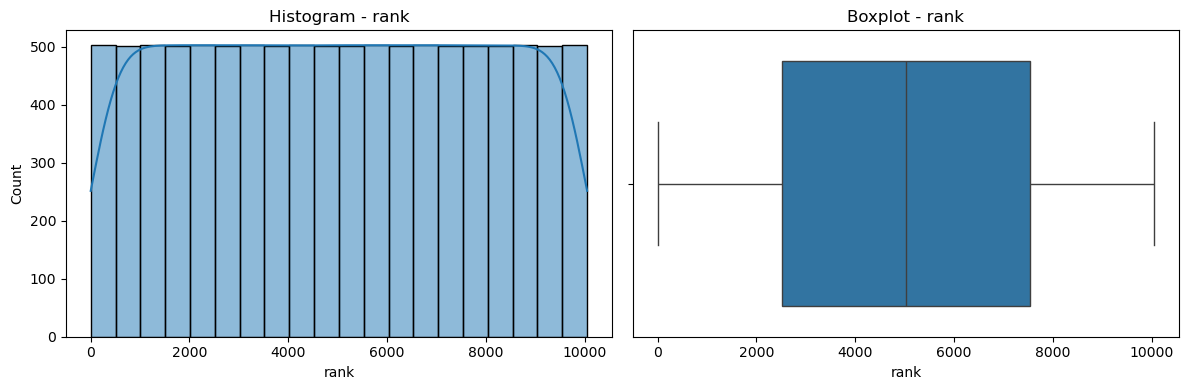

ANALYSIS FOR COLUMN: budget
Distribution shape:  Right
count          6,644.00
mean      33,783,980.40
std       45,764,522.64
min                0.75
25%        5,000,000.00
50%       17,000,000.00
75%       42,000,000.00
max      414,900,000.00
Name: budget, dtype: object
Min value is reasonable
Max value is unreasonable
            Value          Label
0    120000000.00  Extreme value
1    130000000.00  Extreme value
2    110000000.00  Extreme value
3    105000000.00  Extreme value
9    200000000.00  Extreme value
...           ...            ...
8763 112000000.00  Extreme value
8813 126000000.00  Extreme value
8821 110000000.00  Extreme value
9676 113000000.00  Extreme value
9720 137000000.00  Extreme value

[592 rows x 2 columns]
Missing values: 3404 / 10048 (33.88%)
Invalid values: Series([], Name: budget, dtype: float64)
Placeholder values: Series([], Name: budget, dtype: float64)


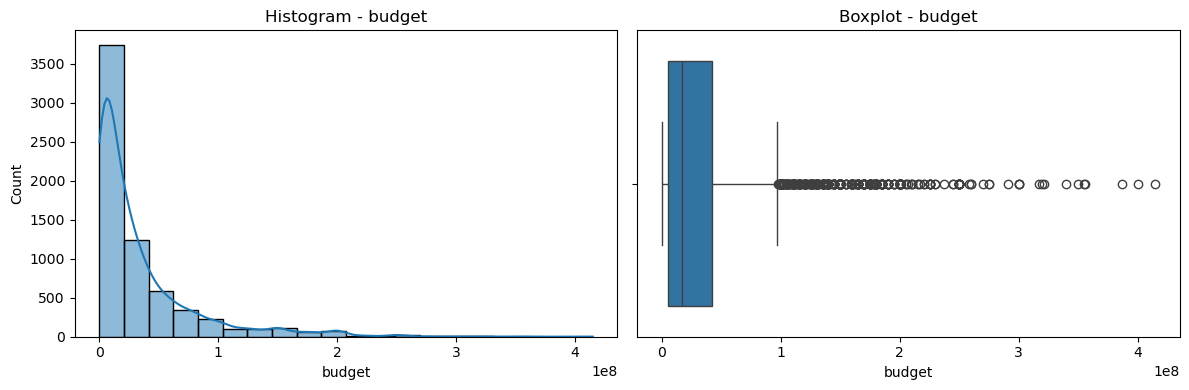

ANALYSIS FOR COLUMN: release_year
Distribution shape:  Left
count    9,880.00
mean     2,006.18
std         18.98
min      1,911.00
25%      1,997.00
50%      2,011.00
75%      2,022.00
max      2,031.00
Name: release_year, dtype: object
Min value is unreasonable
Max value is reasonable
        Value          Label
197   1957.00  Extreme value
342   1946.00  Extreme value
427   1939.00  Extreme value
613   1942.00  Extreme value
639   1958.00  Extreme value
...       ...            ...
9971  1943.00  Extreme value
9985  1948.00  Extreme value
9987  1949.00  Extreme value
10011 1937.00  Extreme value
10038 1931.00  Extreme value

[316 rows x 2 columns]
Missing values: 168 / 10048 (1.67%)
Invalid values: Series([], Name: release_year, dtype: float64)
Placeholder values: Series([], Name: release_year, dtype: float64)


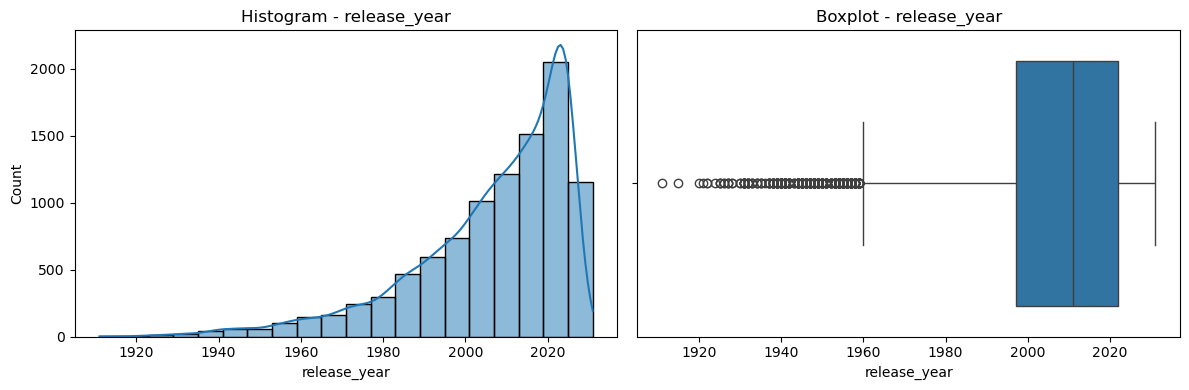

ANALYSIS FOR COLUMN: run_time
Distribution shape:  Right
count    9,668.00
mean       110.08
std         22.95
min         44.00
25%         95.00
50%        106.00
75%        120.00
max        566.00
Name: run_time, dtype: object
Min value is unreasonable
Max value is unreasonable
       Value          Label
1     161.00  Extreme value
19    160.00  Extreme value
60    165.00  Extreme value
69    175.00  Extreme value
70    169.00  Extreme value
...      ...            ...
9882  164.00  Extreme value
9931  162.00  Extreme value
9971  170.00  Extreme value
10007  55.00  Extreme value
10022 173.00  Extreme value

[345 rows x 2 columns]
Missing values: 380 / 10048 (3.78%)
Invalid values: Series([], Name: run_time, dtype: float64)
Placeholder values: Series([], Name: run_time, dtype: float64)


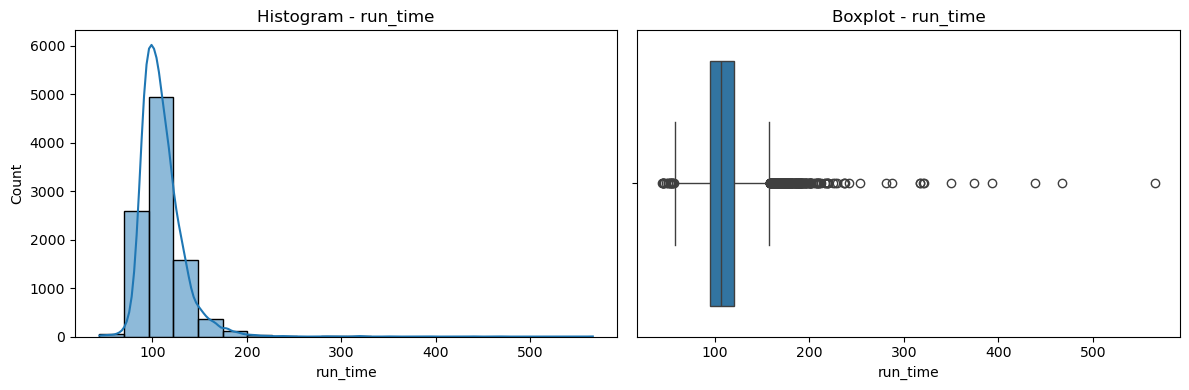

ANALYSIS FOR COLUMN: metascore
Distribution shape:  Normal
count    7,638.00
mean        60.25
std         17.44
min          1.00
25%         48.00
50%         61.00
75%         73.00
max        100.00
Name: metascore, dtype: object
Min value is unreasonable
Max value is reasonable
      Value          Label
1342   6.00  Extreme value
3686   9.00  Extreme value
3821   9.00  Extreme value
5615   9.00  Extreme value
8003   9.00  Extreme value
8219   5.00  Extreme value
8807  10.00  Extreme value
9901   1.00  Extreme value
Missing values: 2410 / 10048 (23.98%)
Invalid values: Series([], Name: metascore, dtype: float64)
Placeholder values: Series([], Name: metascore, dtype: float64)


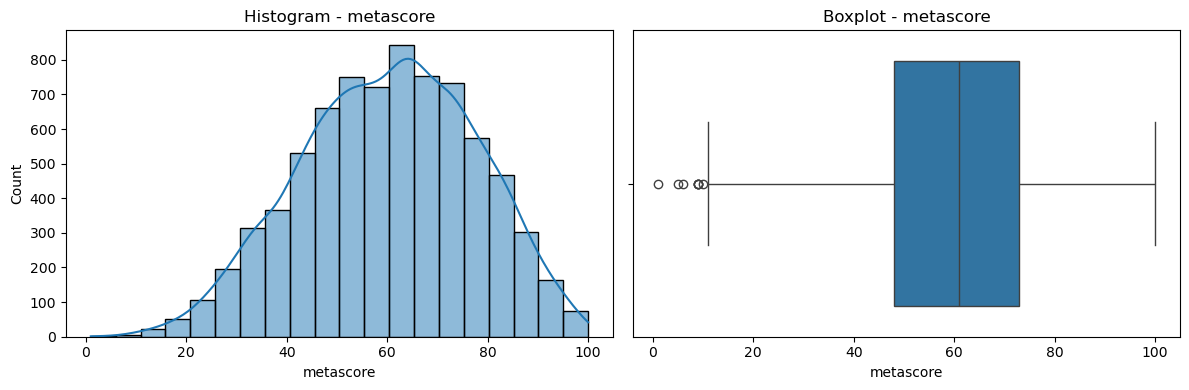

ANALYSIS FOR COLUMN: vote_count
Distribution shape:  Right
count        9,636.00
mean       104,964.87
std        194,809.02
min              6.00
25%         14,000.00
50%         42,000.00
75%        110,000.00
max      3,100,000.00
Name: vote_count, dtype: object
Min value is reasonable
Max value is unreasonable
          Value          Label
32    755000.00  Extreme value
35    351000.00  Extreme value
38    314000.00  Extreme value
45   3100000.00  Extreme value
46    350000.00  Extreme value
...         ...            ...
4707  334000.00  Extreme value
4764  269000.00  Extreme value
4945  313000.00  Extreme value
4961  306000.00  Extreme value
5831  578000.00  Extreme value

[971 rows x 2 columns]
Missing values: 412 / 10048 (4.10%)
Invalid values: Series([], Name: vote_count, dtype: float64)
Placeholder values: Series([], Name: vote_count, dtype: float64)


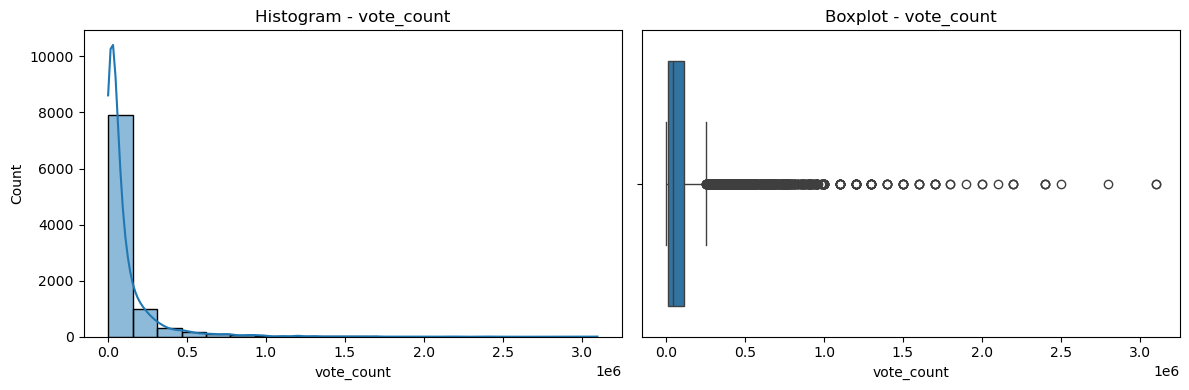

ANALYSIS FOR COLUMN: rating
Distribution shape:  Left
count    9,636.00
mean         6.64
std          0.96
min          1.90
25%          6.10
50%          6.70
75%          7.30
max          9.70
Name: rating, dtype: object
Min value is unreasonable
Max value is unreasonable
       Value          Label
45      9.30  Extreme value
69      9.20  Extreme value
74      3.90  Extreme value
209     4.20  Extreme value
324     4.10  Extreme value
...      ...            ...
9954    3.50  Extreme value
10000   4.20  Extreme value
10003   4.00  Extreme value
10030   3.20  Extreme value
10042   3.10  Extreme value

[162 rows x 2 columns]
Missing values: 412 / 10048 (4.10%)
Invalid values: Series([], Name: rating, dtype: float64)
Placeholder values: Series([], Name: rating, dtype: float64)


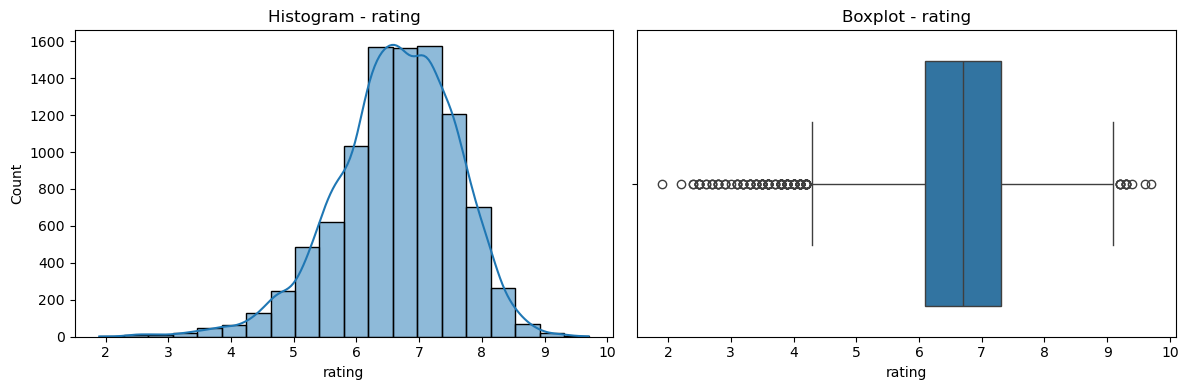

In [28]:
for col in numerical_cols:
    numerical_columns_analysis(col)
    plots(col)

- Tính ma trận tương quan giữa các cột số (numerical columns)

In [29]:
corr = df[numerical_cols].corr()
corr

,rank,budget,release_year,run_time,metascore,vote_count,rating
rank,1.00,-0.29,-0.12,-0.18,-0.16,-0.48,-0.21
budget,-0.29,1.00,0.25,0.22,-0.15,0.39,-0.07
release_year,-0.12,0.25,1.00,-0.02,-0.19,-0.03,-0.28
run_time,-0.18,0.22,-0.02,1.00,0.20,0.21,0.33
metascore,-0.16,-0.15,-0.19,0.20,1.00,0.18,0.71
vote_count,-0.48,0.39,-0.03,0.21,0.18,1.00,0.31
rating,-0.21,-0.07,-0.28,0.33,0.71,0.31,1.00


- Vẽ heatmap ma trận tương quan của các cột số
- Cột nào có **tương quan mạnh** → gần 1 hoặc -1.
- Cột nào **không tương quan** → gần 0.

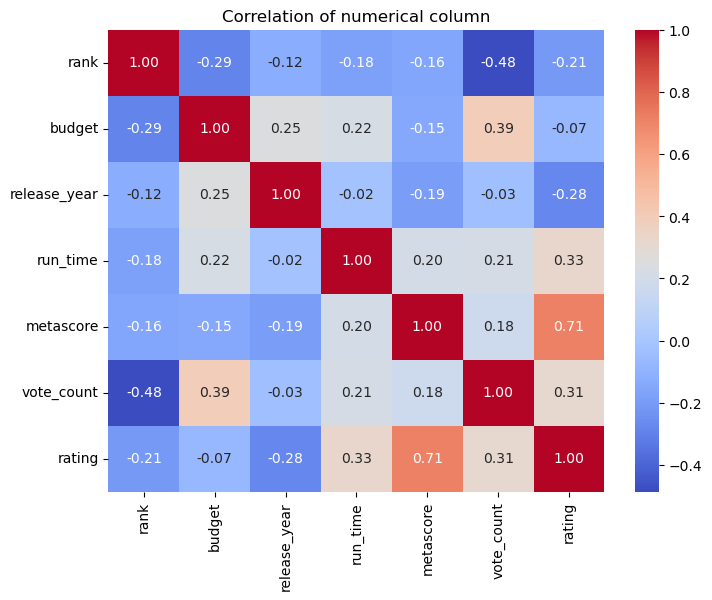

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation of numerical column")
plt.show()

- Dựa vào visualization về mối tương quan giữa các cột số trên:
  + Hầu như các cột số không có quá nhiều tương quan với nhau, điều này cho thấy nhiều đặc trưng mang tính độc lập, ví dụ như: budget.
  + Ngoài ra, ta có thể thấy được mối tương quan mạnh mẽ giữa cột `metascore` và `rating`, điều này cho thấy điểm đánh giá của chuyên gia có ảnh hưởng lớn đến điểm đánh giá của khán giả.

- Vẽ pairplot (scatter plot cho tất cả các cặp cột số)
- Mục đích:
    + Phát hiện outliers hoặc clusters tiềm năng trong dữ liệu.
    + Quan sát tương quan, xu hướng tuyến tính hoặc phi tuyến giữa các cột số.

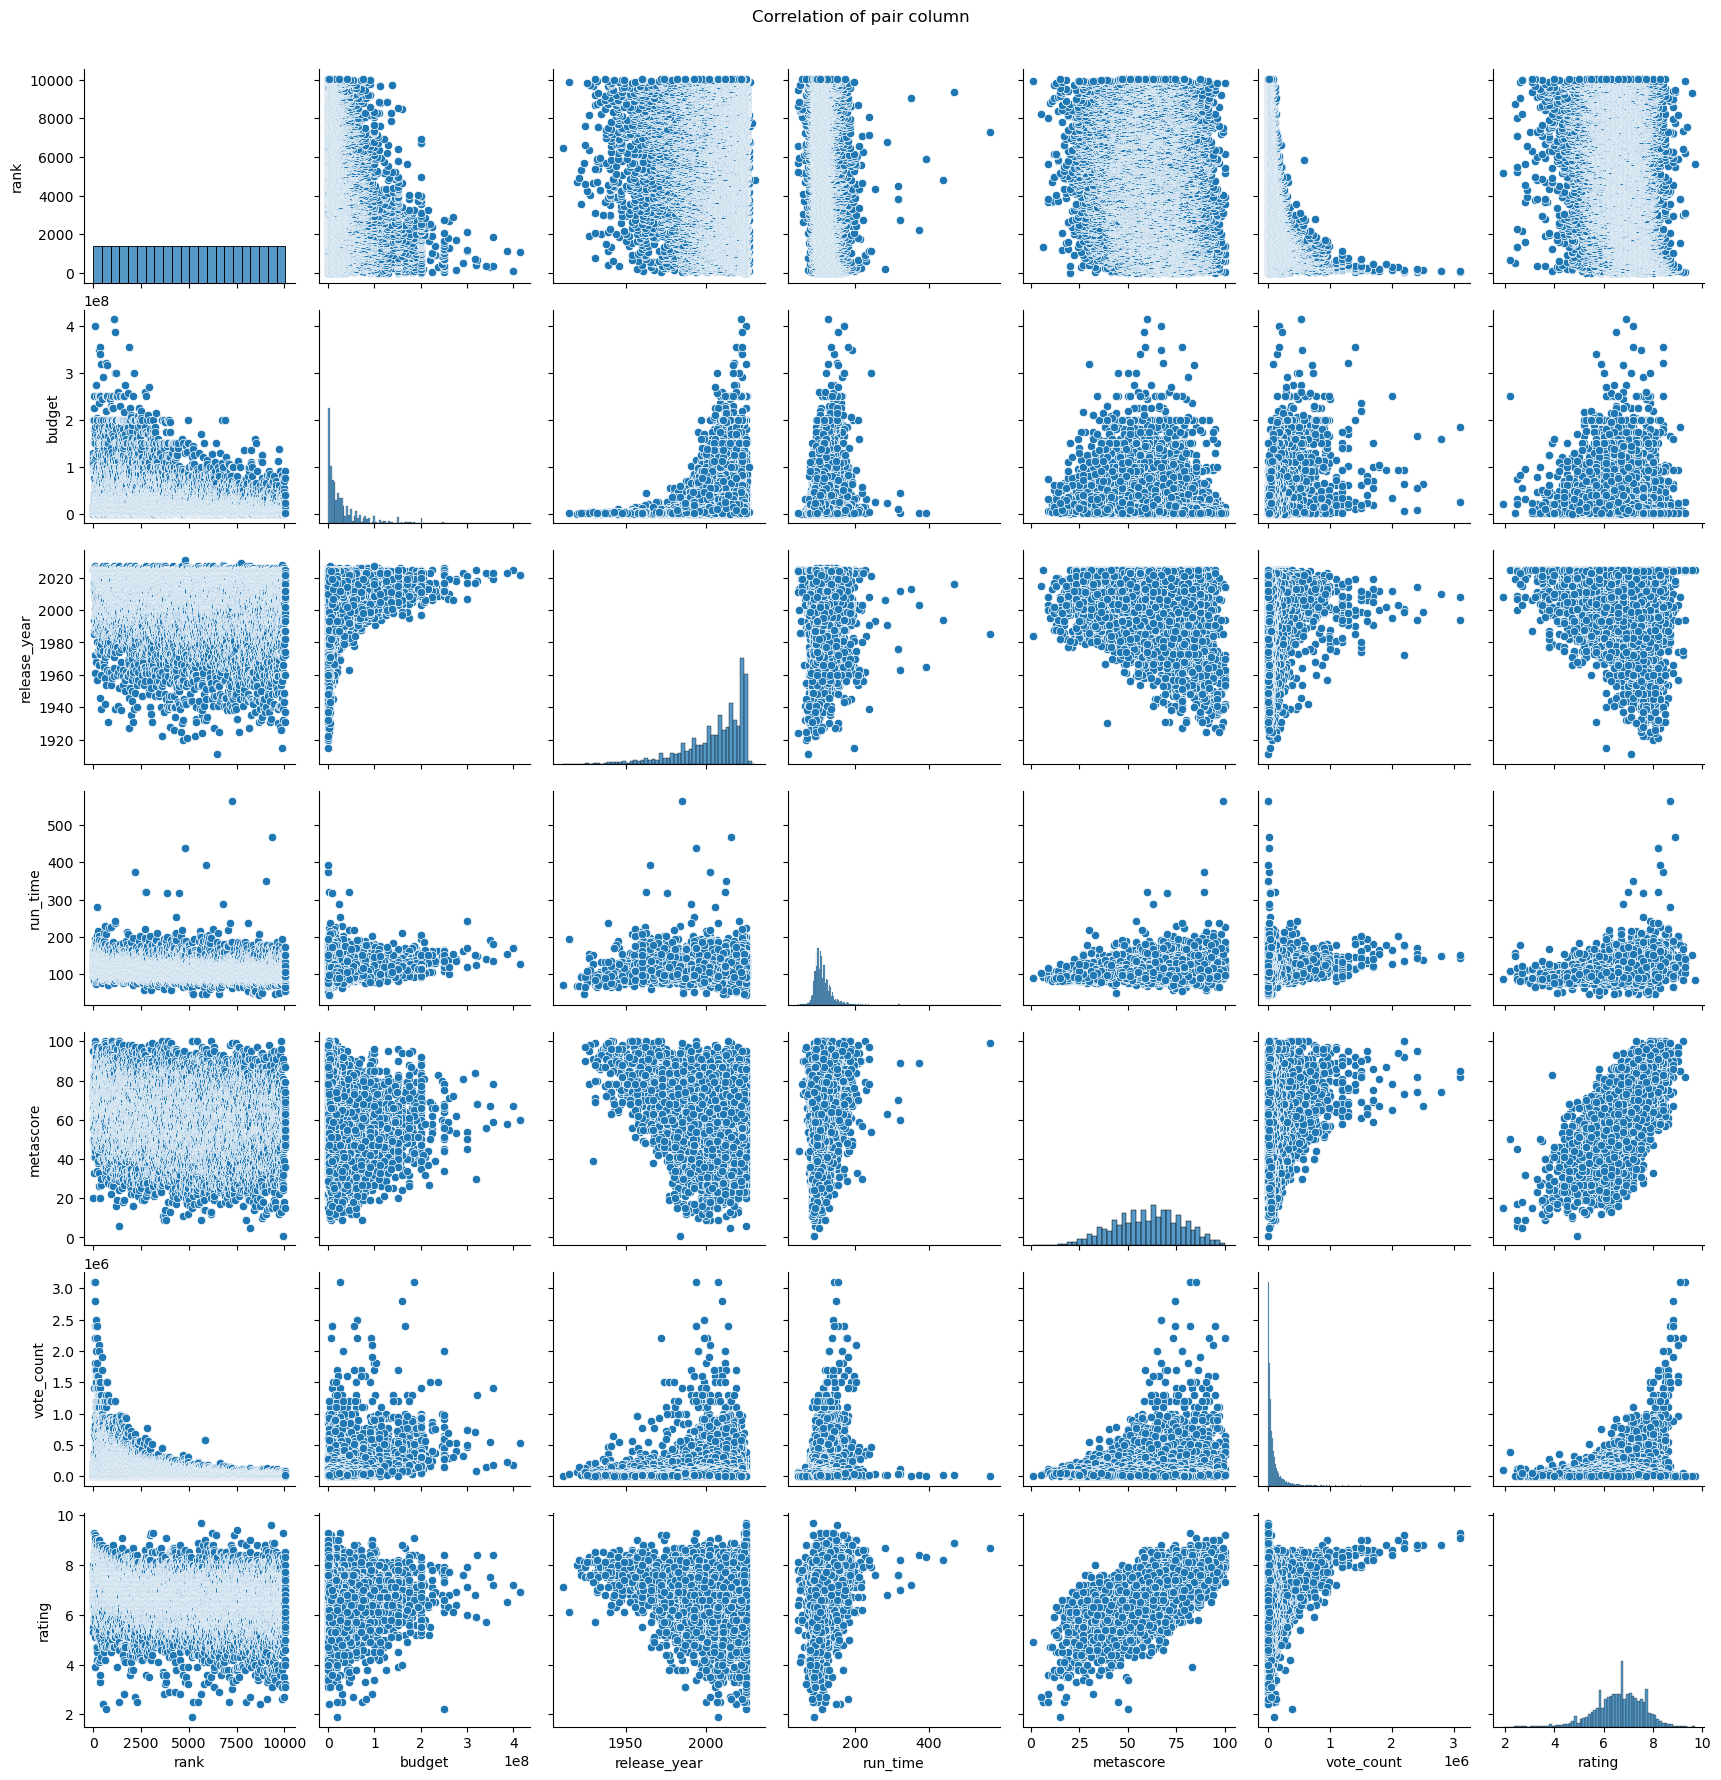

In [31]:
sns.pairplot(df[numerical_cols])
plt.suptitle('Correlation of pair column', y=1.02)  
plt.show()

- Dựa vào visualization về tương quan giữa các cặp cột số trên:

- Cột `metascore` và `rating`: 
  + Có sự **tương quan dương (Positive Correlation)** rõ rệt. Khi điểm đánh giá của chuyên gia (`metascore`) tăng thì điểm của khán giả (`rating`) cũng có xu hướng tăng.

- Cột `vote_count` và `rating`:
  + Tạo thành hình phễu. Các phim có lượng vote cao thường có `rating` ổn định ở mức khá trở lên (> 6.0). Phim dở thường ít người quan tâm bình chọn.

- Cột `run_time` và `rating`:
  + Các bộ phim có thời lượng nhiều hơn 200 phút thường có `rating` cao hơn 7.0, cho thấy xu hướng người xem ưa chuộng các bộ phim dài hơ

### Phân tích trên các cột dữ liệu thuộc loại categorical

- Thực hiện ép kiểu các col thuộc loại categorical mặc định
- Lấy danh sách các cột categorical

In [32]:
df['mpa'] = df['mpa'].astype('category')
df['genres'] = df['genres'].astype('category')

category_cols = df.select_dtypes(include=['category']).columns
category_cols

Index(['genres', 'mpa'], dtype='object')

- Xử lý đặc biệt cho cột 'genres' (Preprocessing)
    Vì cột thể loại phim thường chứa nhiều giá trị trong một ô (ví dụ: *"Action, Adventure, Sci-Fi"*), nên không thể đếm trực tiếp. Code xử lý như sau:
    - `df[col].str.split(', ')`: Cắt chuỗi ban đầu thành một danh sách (List) các thể loại.
    - `df.explode('genres_list')`: Kỹ thuật "bùng nổ" dữ liệu. Nó tách một dòng chứa list 3 phần tử thành 3 dòng riêng biệt.
        - Ví dụ: Dòng phim A có thể loại `[Action, Comedy]` sẽ tách thành 2 dòng: một dòng là `Action`, một dòng là `Comedy`.
        - Mục đích: Giúp hàm `value_counts()` đếm chính xác số lượng phim thuộc từng thể loại riêng lẻ.

- Thống kê cơ bản (Basic Statistics)
  - `unique()`: Liệt kê tên các danh mục đang có (ví dụ: Action, Drama, Horror...).
  - `nunique()`: Đếm tổng số lượng danh mục (ví dụ: có tất cả 18 thể loại phim).
  - `value_counts().head(10)`: Đếm số lần xuất hiện và chỉ lấy 10 danh mục phổ biến nhất để tránh làm rối màn hình.
  - `normalize=True`: Chuyển đổi từ số lượng đếm sang tỷ lệ phần trăm (0-100%) để dễ so sánh.
- Thuật toán kiểm tra mất cân bằng (Imbalance Check)
    Code tự động đánh giá độ lệch của dữ liệu dựa trên tỷ lệ của nhóm đa số (`max_ratio`):
    - Nếu > 80%: Dữ liệu bị lệch nghiêm trọng (Highly imbalanced). Mô hình học máy có thể bị thiên kiến, chỉ dự đoán ra nhóm đa số này.
    - Nếu > 50%: Có sự chênh lệch đáng kể (Some imbalance), cần lưu ý khi chia tập train/test.
    - Còn lại: Dữ liệu phân phối khá đồng đều (Fairly balanced).

- Kiểm tra chất lượng dữ liệu (Data Quality)
  - Missing values: Tính tỷ lệ phần trăm ô trống (NaN).
  - Rare categories: Lọc ra các danh mục xuất hiện dưới 5 lần.

- Trực quan hóa (Visualization)
  - Sử dụng biểu đồ thanh ngang `barh` để hiển thị Top 10.
  - Hàm `ax.bar_label`: Tự động điền con số cụ thể vào đầu mỗi thanh biểu đồ giúp người xem không cần gióng mắt xuống trục hoành để ước lượng.

In [33]:
def category_analysis(col):
    if col == 'genres':
        # Split để tạo list
        df['genres_list'] = df[col].str.split(', ')
        # Explode nhưng KHÔNG ghi đè df gốc
        temp = df.explode('genres_list')
        col_to_analyze = 'genres_list'
    else:
        temp = df.copy()
        col_to_analyze = col

    print("="*60)
    print(f"ANALYSIS FOR COLUMN: {col}")
    print("="*60)

    # Unique values
    print("\nUnique/distinct values:")
    print(temp[col_to_analyze].unique())
    
    # Number of unique values
    print("\nNumber of unique values:")
    print(temp[col_to_analyze].nunique())

    # Top 10 most frequent
    print("\nTop 10 most frequent values:")
    print(temp[col_to_analyze].value_counts().head(10))

    # Normalized frequency %
    print("\nPercentage distribution:")
    print((temp[col_to_analyze].value_counts(normalize=True) * 100).head(10))

    # Balance check
    print("\nBalance check:")
    dist = temp[col_to_analyze].value_counts(normalize=True) * 100
    max_ratio = dist.iloc[0]

    if max_ratio > 80:
        print("Distribution is **highly imbalanced**.")
    elif max_ratio > 50:
        print("Some imbalance present.")
    else:
        print("Distribution is fairly balanced.")

    missing_pct = df[col].isna().mean() * 100
    print(f"\nMissing values: {missing_pct:.2f}%")

    freq = temp[col_to_analyze].value_counts()
    rare = freq[freq < 5]     
    print("\nRare categories:")
    print(rare);

    # Visualization
    plt.figure(figsize=(10, 5))
    ax = temp[col_to_analyze].value_counts().head(10).plot(kind='barh')
    ax.bar_label(ax.containers[0], padding=3)
    plt.title(f"\nTop 10 Frequent Values in '{col}'")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.show();

ANALYSIS FOR COLUMN: genres

Unique/distinct values:
['Drama' 'Fantasy' 'Horror' 'Sci-Fi' 'Action' 'Crime' 'Thriller'
 'Adventure' 'Comedy' 'Biography' 'History' 'War' 'Music' 'Romance'
 'Mystery' 'Western' 'Animation' 'Family' 'Musical' 'Sport' nan
 'Documentary' 'Film-Noir' 'News']

Number of unique values:
23

Top 10 most frequent values:
genres_list
Drama        5695
Thriller     3342
Comedy       3169
Action       2304
Romance      2015
Crime        1874
Adventure    1688
Horror       1574
Mystery      1442
Sci-Fi       1225
Name: count, dtype: int64

Percentage distribution:
genres_list
Drama       19.02
Thriller    11.16
Comedy      10.58
Action       7.70
Romance      6.73
Crime        6.26
Adventure    5.64
Horror       5.26
Mystery      4.82
Sci-Fi       4.09
Name: proportion, dtype: float64

Balance check:
Distribution is fairly balanced.

Missing values: 1.32%

Rare categories:
genres_list
News    1
Name: count, dtype: int64


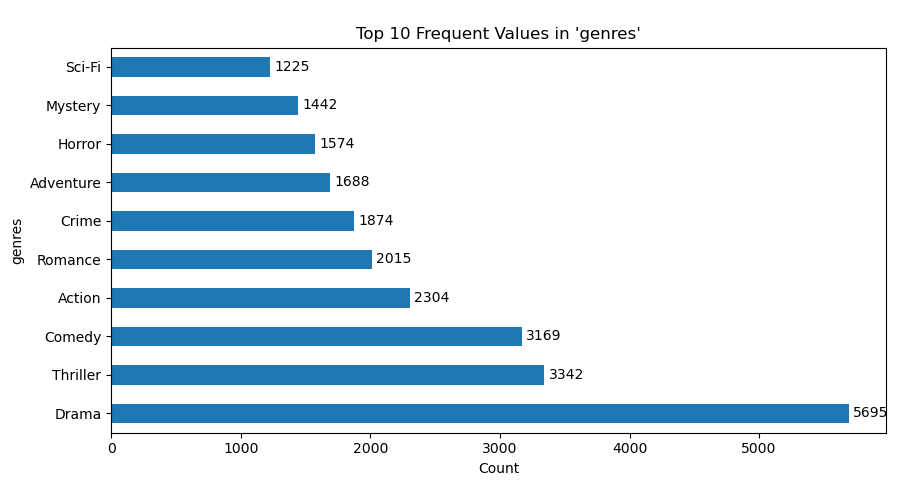

ANALYSIS FOR COLUMN: mpa

Unique/distinct values:
['R', 'PG-13', NaN, 'PG', 'TV-PG', ..., '16+', 'M', 'TV-Y7', 'MA-17', 'TV-Y']
Length: 24
Categories (23, object): ['13+', '16+', '18+', 'Approved', ..., 'TV-Y', 'TV-Y7', 'Unrated', 'X']

Number of unique values:
23

Top 10 most frequent values:
mpa
R            3763
PG-13        2005
PG           1109
Not Rated     746
Approved      297
TV-MA         256
G             192
Unrated       124
TV-14          89
TV-PG          37
Name: count, dtype: int64

Percentage distribution:
mpa
R           43.17
PG-13       23.00
PG          12.72
Not Rated    8.56
Approved     3.41
TV-MA        2.94
G            2.20
Unrated      1.42
TV-14        1.02
TV-PG        0.42
Name: proportion, dtype: float64

Balance check:
Distribution is fairly balanced.

Missing values: 13.26%

Rare categories:
mpa
16+      4
M/PG     4
X        4
TV-Y7    3
MA-17    1
TV-Y     1
Name: count, dtype: int64


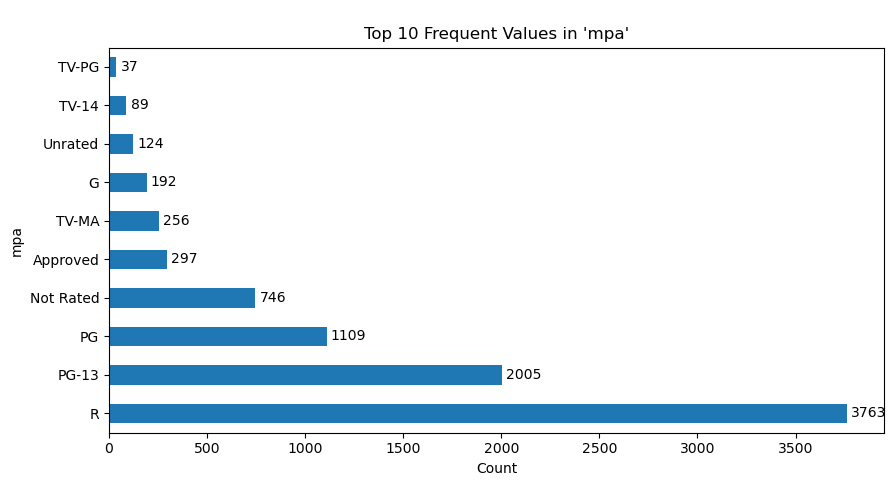

In [34]:
for col in category_cols:
    category_analysis(col);

### Visualize mối quan hệ giữa Genres và MPA

#### 1. Cấu hình
- top_n_genres = 15: Lấy top 15 genres phổ biến
- genre_col = 'genres': cột chứa thể loại phim
- category_col = 'mpa': cột chứa rating phim

#### 2. Copy dataset
- df_exploded = df.copy(): tạo bản sao dataset để không làm thay đổi gốc

#### 3. Tách genres thành list
- df_exploded[genre_col] = df_exploded[genre_col].str.split(', ')
- Nếu 1 phim có nhiều thể loại, tách các thể loại thành list

#### 4. Explode
- df_exploded = df_exploded.explode(genre_col)
- Mỗi thể loại trở thành 1 dòng riêng

#### 5. Lấy top N genres
- top_genres = df_exploded[genre_col].value_counts().head(top_n_genres).index

#### 6. Lọc dataset chỉ chứa top genres
- df_top = df_exploded[df_exploded[genre_col].isin(top_genres)]

#### 7. Tạo cross-tab
- cross_tab = pd.crosstab(df_top[genre_col], df_top[category_col])
- Hàng: genres (top 15)
- Cột: MPA ratings
- Giá trị: số lượng phim thuộc cặp (genre, mpa)

#### Mục đích
- Xem mối quan hệ giữa thể loại phim và rating
- Sử dụng cross-tab để vẽ heatmap hoặc stacked bar chart

In [35]:
top_n_genres = 15  # Lấy top 15 genres phổ biến
genre_col = 'genres'
category_col = 'mpa'

df_exploded = df.copy()
df_exploded[genre_col] = df_exploded[genre_col].str.split(', ')
df_exploded = df_exploded.explode(genre_col)

top_genres = df_exploded[genre_col].value_counts().head(top_n_genres).index
df_top = df_exploded[df_exploded[genre_col].isin(top_genres)]

cross_tab = pd.crosstab(df_top[genre_col], df_top[category_col])

- Vẽ heatmap số lượng phim theo Genres và MPA
- Mục đích:
  + Nhận biết thể loại nào phổ biến theo từng rating

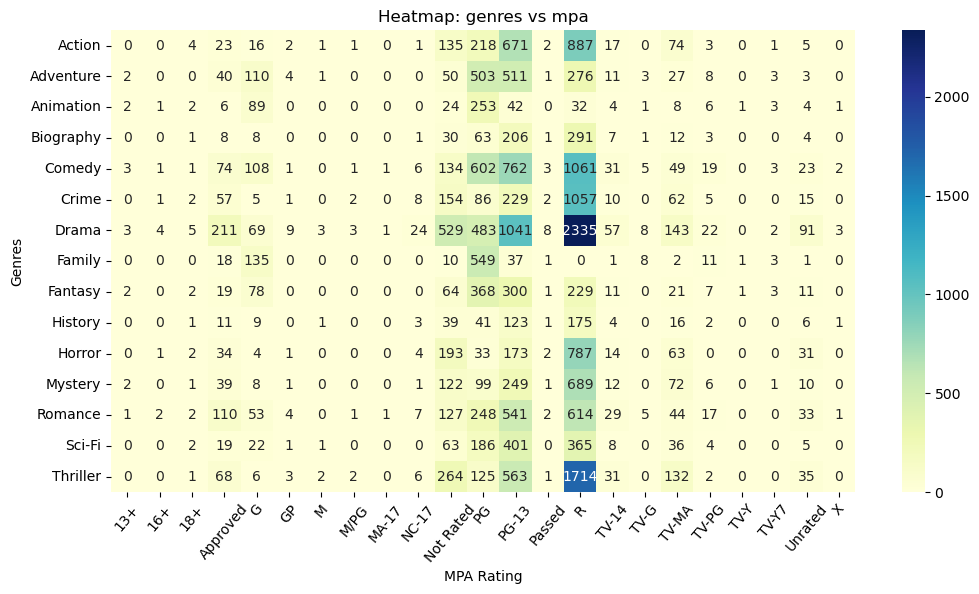

In [36]:
plt.figure(figsize=(12,6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title(f"Heatmap: {genre_col} vs {category_col}")
plt.ylabel("Genres")
plt.xticks(rotation=50)
plt.xlabel("MPA Rating")
plt.show()

- Dựa vào visualization Heatmap trên:
+ Bộ phim với thể loại Drama có số lượng lớn nhất trong các thể loại phim với phân loại MPA là R.
+ Các thể loại phim, hầu hết đều tập trung vào phân loại MPA là R và PG-13, cho thấy xu hướng phổ biến của các thể loại phim này đối với khán giả trưởng thành và thanh thiếu niên. 

- Vẽ stacked bar chart tỷ lệ MPA theo Genres
- Mục đích:
    + Quan sát **tỉ lệ MPA rating trong từng thể loại phim**
    + Nhìn trực quan thể loại nào có rating phổ biến nhất

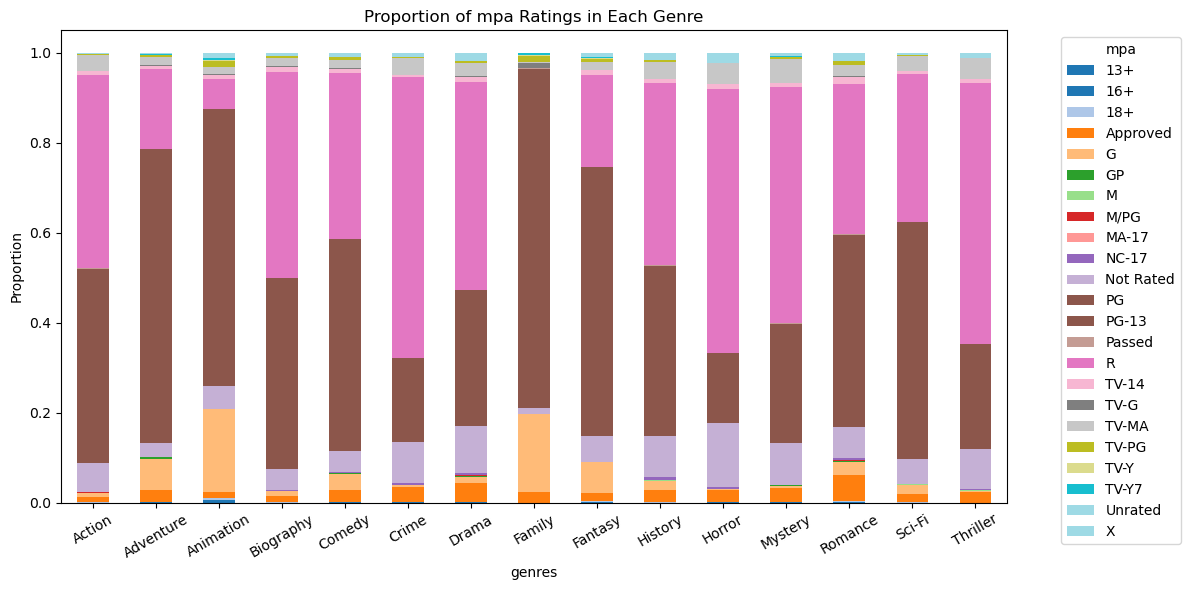

In [37]:
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)  # chuyển sang tỉ lệ
cross_tab_norm.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.ylabel("Proportion")
plt.title(f"Proportion of {category_col} Ratings in Each Genre")
plt.xticks(rotation=30)
plt.legend(title=category_col, bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

- Dựa vào stacked bar chart trên:
+ Hầu như các phân loại PG-13 và R chiếm tỷ lệ lớn, cho thấy xu hướng phát triển phim chủ yếu đánh vào các khán giả này

### Phân tích cho missing values

Nhóm tính toán tỉ lệ các missing values cho mỗi đặc trưng, kết quả như sau

In [38]:
def compute_missing_values(df, cols_to_check):
    missing_data = df[cols_to_check].isnull().sum()
    missing_percent = (df[cols_to_check].isnull().sum() / len(df)) * 100
    
    missing_df = pd.DataFrame({'Missing Count': missing_data, 'Percentage (%)': missing_percent})
    missing_df = missing_df[missing_df['Missing Count'] >= 0].sort_values(by='Percentage (%)', ascending=False)
    
    return missing_df
    
cols_to_check = ['rank', 'title', 'budget', 'metascore', 'mpa', 'vote_count', 'rating', 'run_time', 'release_year', 'genres']
missing_df = compute_missing_values(df, cols_to_check)
missing_df

,Missing Count,Percentage (%)
budget,3404,33.88
metascore,2410,23.98
mpa,1332,13.26
vote_count,412,4.10
rating,412,4.10
run_time,380,3.78
release_year,168,1.67
genres,133,1.32
title,0,0.00
rank,0,0.00


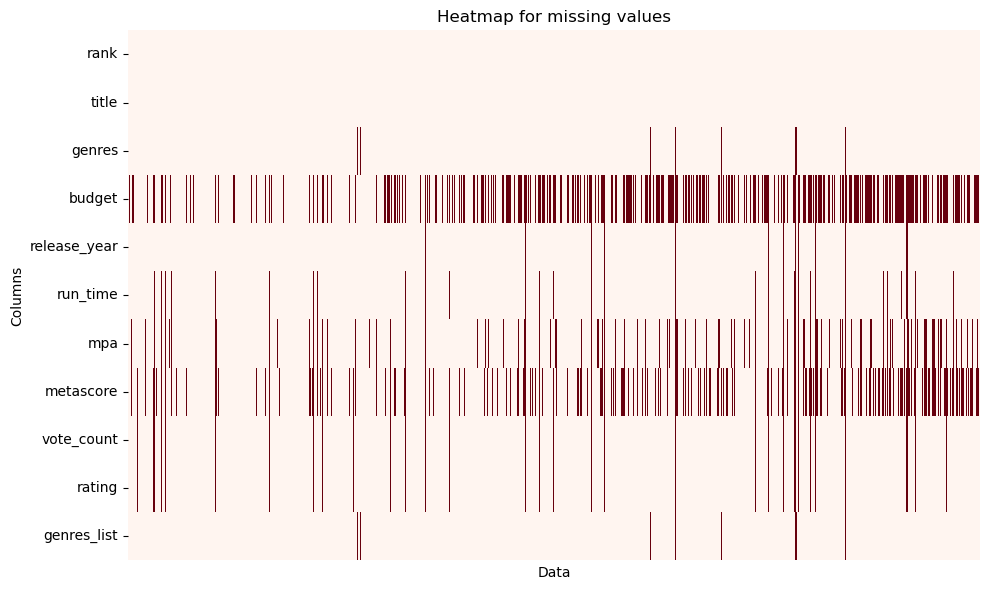

In [39]:
plt.figure(figsize=(10, 6))

sns.heatmap(
    df.isnull().T,
    cbar=False,
    xticklabels=False,
    cmap='Reds'  
)

plt.title('Heatmap for missing values')
plt.xlabel('Data')
plt.ylabel('Columns')

plt.tight_layout()
plt.show()

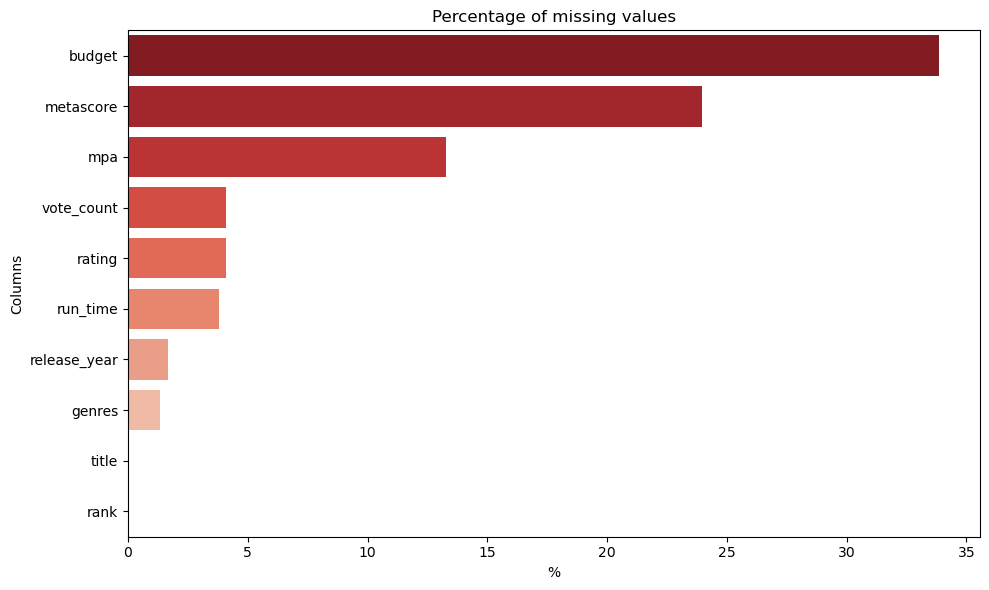

In [40]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x=missing_df['Percentage (%)'], 
    y=missing_df.index,            
    hue=missing_df.index,           
    palette='Reds_r', 
    legend=False
)

plt.title('Percentage of missing values')
plt.xlabel('%')
plt.ylabel('Columns')

plt.tight_layout()
plt.show()

Vì đồ án hướng đến bài toán dự đoán điểm `rating`, ở các dòng dữ liệu thiếu giá trị `rating` nhóm quyết định xoá hẳn dòng đó khỏi dataset để khi xây dựng mô hình sẽ không bị sai lệch. 

In [41]:
df = df.dropna(how='any', subset=['rating'], axis=0)

Để tránh rò rỉ dữ liệu (Data Leakage), ngay sau khi loại bỏ dòng dữ liệu thiếu của `rating` nhóm thực hiện ngay việc chia tập dữ liệu để xử lí missing values trên 2 tập Train và Test:
- Xác định các đặc trưng (Features) và mục tiêu (Target).
- Chia dữ liệu thành 2 phần `X_train` và `X_test` theo tỉ lệ Train (80%) và Test (20%) với cấu hình `random_state=42` giúp kết quả chia dữ liệu ổn định qua mỗi lần chạy.

In [42]:
features = ['title', 'budget', 'metascore', 'mpa', 'vote_count', 'run_time', 'release_year', 'genres']
target = 'rating'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Total: {len(df)}")
print(f"Size of Train Set (X_train): {len(X_train)}")
print(f"Size of Test Set (X_test): {len(X_test)}")

Total: 9636
Size of Train Set (X_train): 7708
Size of Test Set (X_test): 1928


Ở đặc trưng `mpa`, để xử lý missing values nhóm quyết định điền giá trị "Unrated" vì có thể  phim chưa được gửi đi kiểm duyệt hoặc là phim cũ/phim nước ngoài không theo hệ thống MPAA của Mỹ.

In [43]:
X_train['mpa'] = X_train['mpa'].fillna('Unrated')
X_test['mpa'] = X_test['mpa'].fillna('Unrated')

Với `genres` thì nhóm dùng mode để giải quyết missing values vì đây là dữ liệu categorical, không thể tính median.

In [44]:
genres_mode = X_train['genres'].mode()[0] 
X_train['genres'] = X_train['genres'].fillna(genres_mode)
X_test['genres'] = X_test['genres'].fillna(genres_mode)

Với các đặc trưng numerical còn lại là `release_year`, `vote_count`, `run_time` thì nhóm dùng median thay cho mean để điền vào các missing values. Lí do là vì median sẽ tránh cho dữ liệu bị lệch bởi sự ảnh hưởng của các giá trị ngoại lai.

In [45]:
release_year_median = np.nanmedian(X_train['release_year'])
X_train['release_year'] = X_train['release_year'].fillna(release_year_median)
X_test['release_year'] = X_test['release_year'].fillna(release_year_median)

vote_count_median = np.nanmedian(X_train['vote_count'])
X_train['vote_count'] = X_train['vote_count'].fillna(vote_count_median)
X_test['release_year'] = X_test['release_year'].fillna(release_year_median)

run_time_median = np.nanmedian(X_train['run_time'])
X_train['run_time'] = X_train['run_time'].fillna(run_time_median)
X_test['run_time'] = X_test['run_time'].fillna(release_year_median)

Với `budget` và `metascore`, đây là 2 đặc trưng có tỉ lệ missing values khá cao. `budget` thiếu có thể vì lí do nhà sản xuất không công khai trên nền tảng IMDb, còn `metascore` thiếu có thể do bộ phim không quá nổi tiếng để được các chuyên gia đánh giá. Dù vậy, nhóm vẫn quyết định xử lí bằng cách sử dụng thuật toán Iterative Imputer để dự đoán giá trị thiếu từ việc lấy dữ liệu của các đặc trưng còn lại, giúp giữ được sự biến thiên tự nhiên để khi xây dựng mô hình học máy sau này (dự đoán Rating) đạt độ chính xác cao hơn so với việc điền median.

Trước khi áp dụng Iterative Imputer, đầu tiên nhóm nhận thấy có 2 đặc trưng `mpa` và `genres` còn đang là kiểu categorical, vậy nên dữ liệu của 2 cột này sẽ được chuyển sang dạng số bằng phương pháp Label Encoding. Lí do cho việc dùng Label Encoding là:
- Đối với `mpa`, cột này có tính chất thứ bậc (Ordinal) nên việc sử dụng Label Encoding sẽ gán cho mỗi nhãn một con số (0, 1, 2...) giúp thuật toán MICE xử lý các con số này rất tốt. Mô hình hồi quy bên trong MICE sẽ nhận ra được xu hướng: Khi con số này tăng lên (độ tuổi hạn chế tăng), thì các biến `budget` hoặc `metascore` cũng thay đổi theo một chiều hướng nhất định.
- Đối với `genres`, mặc dù dữ liệu không có thứ tự, nhưng việc dùng Label Encoding cho phép MICE gom nhóm các phim có cùng mã số lại với nhau. Ví dụ như mô hình có thể hiểu: "Tất cả các phim có mã là '3' (giả sử là Action) đều có xu hướng có budget cao", điều này hiệu quả hơn việc phải kiểm tra 20 cột True/False riêng biệt.

In [46]:
# Trích xuất primary_genres 
X_train['primary_genres'] = X_train['genres'].apply(lambda x: x.split(',')[0].strip())
X_test['primary_genres'] = X_test['genres'].apply(lambda x: x.split(',')[0].strip())

# Khởi tạo Label Encoder
le_mpa = LabelEncoder()
le_genre = LabelEncoder()

# Fit và Transform trên tập Train
X_train['mpa_encoded'] = le_mpa.fit_transform(X_train['mpa'])
X_train['genres_encoded'] = le_genre.fit_transform(X_train['primary_genres'])

# Transform trên tập Test
X_test['mpa_encoded'] = le_mpa.transform(X_test['mpa'])
X_test['genres_encoded'] = le_genre.transform(X_test['primary_genres'])

Thay vì chỉ dùng một giá trị tĩnh là median như cách điền giá trị thiếu cơ bản, Iterative Imputer sẽ coi `budget` và `metascore` là "biến mục tiêu" và sử dụng các đặc trưng còn lại là `release_year`, `vote_count`, `run_time`, `genres` và `mpa` đã được encoded để dự đoán giá trị đó. Điều này giúp bảo toàn mối tương quan giữa các biến (ví dụ như phim có điểm `metascore` cao thường có ngân sách lớn hơn hoặc ngược lại). Cơ chế hoạt động như sau:
- Nó bắt đầu bằng cách điền tạm thời các giá trị thiếu.
- Sau đó, nó coi `budget` là biến mục tiêu ($y$) và các cột khác là biến độc lập ($X$) để dự đoán lại `budget`.
- Tiếp theo, nó làm tương tự với `metascore`.
- Quá trình này lặp đi lặp lại (10 lần theo như cấu hình) cho đến khi các giá trị điền vào ổn định.

In [47]:
features_to_use = ['budget', 'metascore', 'release_year', 'vote_count', 'run_time', 'genres_encoded', 'mpa_encoded']

# Khởi tạo imputer
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42,
    min_value=0  # Đảm bảo không có giá trị âm 
)

# Fit và Transform trên tập Train
# Bước này giúp imputer học mối quan hệ giữa các cột chỉ từ dữ liệu huấn luyện
X_train_imputed_data = imputer.fit_transform(X_train[features_to_use])
X_train[['budget', 'metascore']] = X_train_imputed_data[:, [0, 1]]

# Transform trên tập Test
# Không fit lại để tránh rò rỉ thông tin từ tập test vào mô hình
X_test_imputed_data = imputer.transform(X_test[features_to_use])
X_test[['budget', 'metascore']] = X_test_imputed_data[:, [0, 1]]

/home/duyhoang/anaconda3/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Sau khi xử lí xong toàn bộ các đặc trưng bị thiếu, nhóm kiểm tra lại 1 lần nữa để đảm bảo toàn bộ phần xử lí được hoàn thành đầy đủ.  

In [48]:
features_to_check = ['budget', 'metascore', 'mpa', 'vote_count', 'run_time', 'release_year', 'genres']

compute_missing_values(X_train, features_to_check)

,Missing Count,Percentage (%)
budget,0,0.00
metascore,0,0.00
mpa,0,0.00
vote_count,0,0.00
run_time,0,0.00
release_year,0,0.00
genres,0,0.00


In [49]:
compute_missing_values(X_test, features_to_check)

,Missing Count,Percentage (%)
budget,0,0.00
metascore,0,0.00
mpa,0,0.00
vote_count,0,0.00
run_time,0,0.00
release_year,0,0.00
genres,0,0.00


### Chiến lược chuẩn hoá dữ liệu

#### Nhóm dữ liệu có phân phối lệch (Skewed Data)

Thông qua phân tích trên, có thể thấy `budget` và `vote_count` có phân phối lệch rất lớn.

In [50]:
def plots_for_processed(col):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    sns.histplot(X_train[col], bins=20, kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram - {col}")

    sns.boxplot(x=X_train[col], ax=axes[1])
    axes[1].set_title(f"Boxplot - {col}")

    plt.tight_layout()
    plt.show()

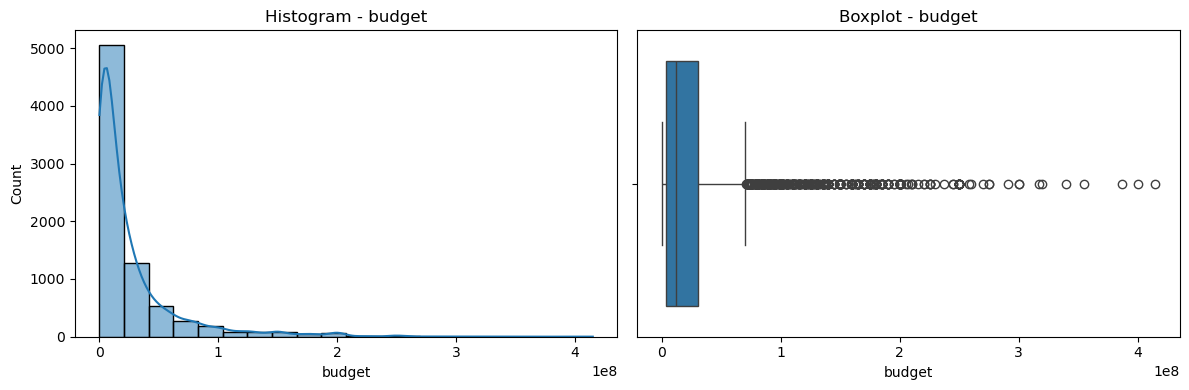

In [51]:
plots_for_processed('budget')

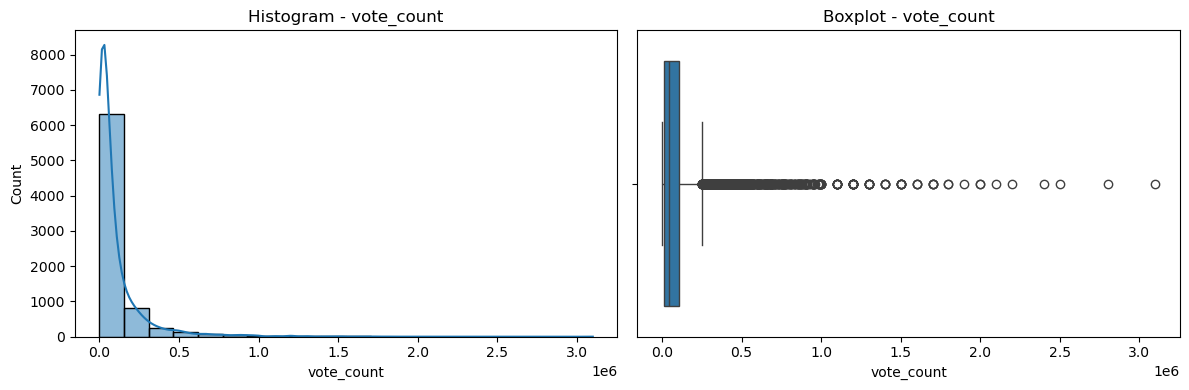

In [52]:
plots_for_processed('vote_count')

Để xử lý hiệu quả nhóm dữ liệu có độ lệch cao (Skewed Data) như `budget` và `vote_count`, nhóm thực hiện quy trình gồm hai bước chính: 
- Chuyển đổi Log (Log Transformation) để thu hẹp khoảng cách các giá trị cực lớn
- Robust Scaling để chuẩn hóa mà không bị ảnh hưởng bởi các giá trị ngoại lệ (outliers).

Quy trình này mang lại hiệu quả như sau: 
- Lấy ví dụ ở dữ liệu của `budget`, một bộ phim nổi tiếng có kinh phí hàng trăm triệu USD, trong khi phim độc lập chỉ vài chục ngàn USD. Khoảng cách này quá lớn có thể khiến việc xây dựng mô hình trở nên kém hiệu quả. Vậy nên phép Log Transformation ($log(1+x)$) được áp dụng để biến các mối quan hệ nhân (multiplicative) thành cộng (additive). Nó kéo các giá trị khổng lồ lại gần hơn với phần còn lại của dữ liệu, giúp biểu đồ Histogram không còn bị đuôi dài về bên phải.
- Ngoài ra, sử dụng RobustScaler thay cho cách thông thường là StandardScaler (Z-score) để tập trung vào giá trị Median thay vì sử dụng giá trị trung bình (Mean) vốn bị kéo lệch rất mạnh bởi các phim bom tấn. Cách hoạt động của RobustScaler là nó trừ đi trung vị và chia cho khoảng cách giữa phân vị 25% và 75%, đảm bảo rằng các giá trị outliers không làm sai lệch thang đo của toàn bộ tập dữ liệu.

In [53]:
cols_to_transform = ['budget', 'vote_count']

# Xử lý Log Transformation (sử dụng log1p để tránh lỗi log(0))
for col in cols_to_transform:
    X_train[f'{col}_log'] = np.log1p(X_train[col])
    X_test[f'{col}_log'] = np.log1p(X_test[col])

# Sử dụng RobustScaler sử dụng Median và IQR (Interquartile Range) 
scaler = RobustScaler()

log_cols = [f'{col}_log' for col in cols_to_transform]
scaled_cols = [f'{col}_scaled' for col in cols_to_transform]

# Fit và Transform trên tập Train
X_train[scaled_cols] = scaler.fit_transform(X_train[log_cols])

# Transform trên tập Test
X_test[scaled_cols] = scaler.transform(X_test[log_cols])

Kiểm tra lại phân phối của 2 cột `budget` và `vote_count`, có thể thấy biểu đồ đã có hình dạng chuông cân đối hơn, giúp cho việc xây dựng các thuật toán học máy về sau hội tụ nhanh hơn và chính xác hơn.

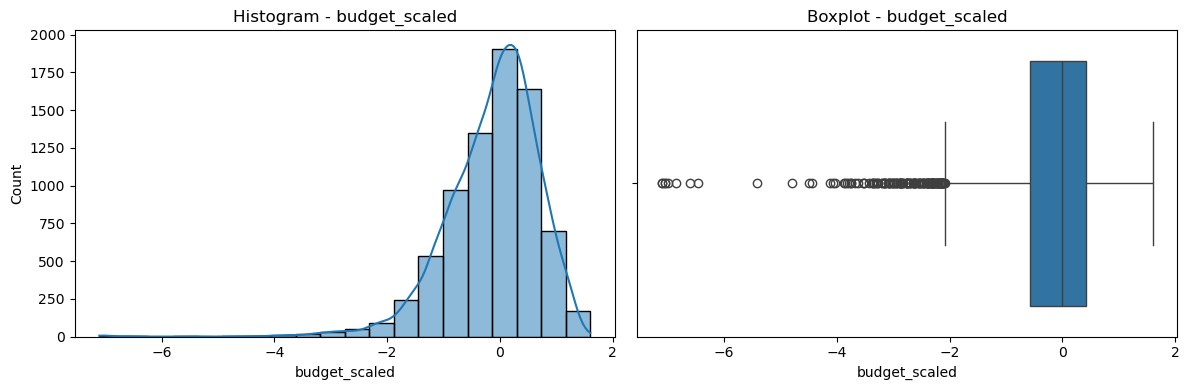

In [54]:
plots_for_processed('budget_scaled')

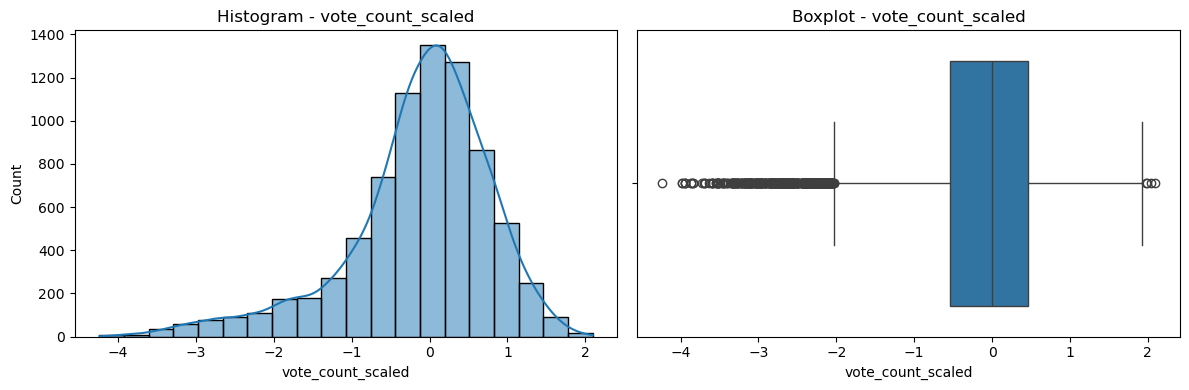

In [55]:
plots_for_processed('vote_count_scaled')

#### Nhóm dữ liệu có biên độ xác định 

Đối với cột dữ liệu `metascore` có biên độ xác định với giới hạn trên và dưới từ 0-100, mục tiêu chính là đưa chúng về cùng một hệ quy chiếu (thường là đoạn $[0, 1]$) mà không làm thay đổi hình dạng phân phối ban đầu của dữ liệu. Ở đây nhóm xác định chiến lược Min-Max Scaling là lựa chọn tối ưu nhất.

Đây là phân phối của cột này trước khi thực hiện Min-Max Scaling

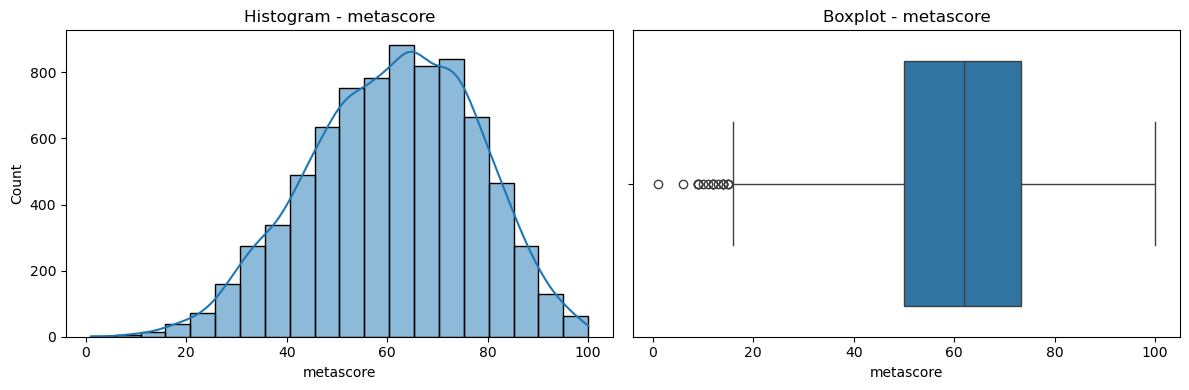

In [56]:
plots_for_processed('metascore')

In [57]:
cols_to_scale = ['metascore']

# Khởi tạo MinMaxScaler
min_max_scaler = MinMaxScaler()

# Thực hiện chuẩn hóa
X_train[[f'{col}_minmax' for col in cols_to_scale]] = min_max_scaler.fit_transform(X_train[cols_to_scale])

X_test[[f'{col}_minmax' for col in cols_to_scale]] = min_max_scaler.transform(X_test[cols_to_scale])

Đây là phân phối của cột sau khi thực hiện Min-Max Scaling, có thể thấy dữ liệu đã scale về đoạn $[0, 1]$ mà không làm thay đổi phân phối gốc.

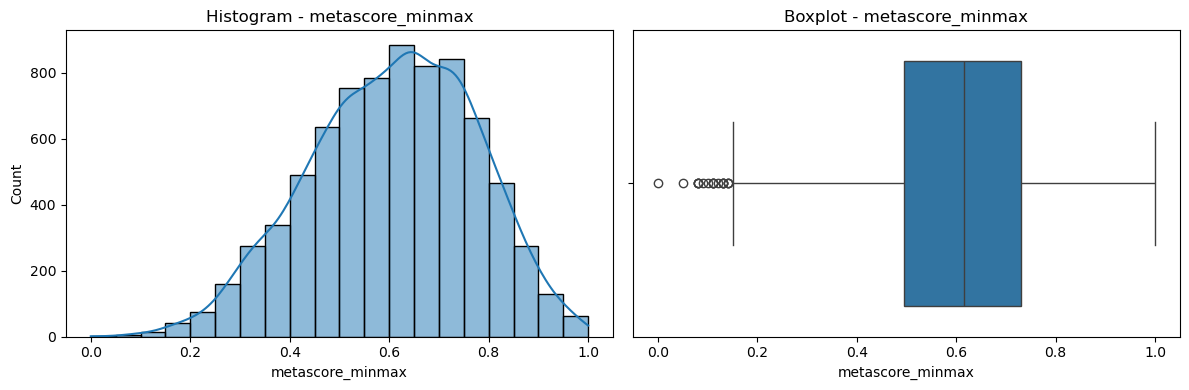

In [58]:
plots_for_processed('metascore_minmax')

#### Nhóm dữ liệu thời gian và thời lượng

Đầu tiên là cột `run_time`, quan sát trên biểu đồ như sau

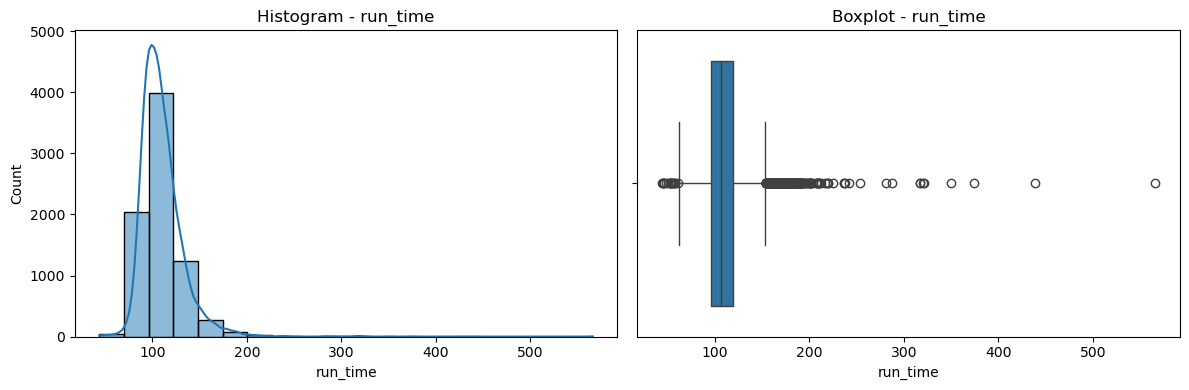

In [59]:
plots_for_processed('run_time')

Đối với `run_time`, phân phối có xu hướng ổn định hơn (nhiều phim dài 90-120 phút, ít phim quá ngắn hoặc quá dài). Vì vậy nhóm quyết định dùng StandardScaler bởi nó làm nổi bật rất tốt các giá trị outliers. Một bộ phim dài 4 tiếng hoặc phim ngắn 15 phút sẽ có giá trị Z-score rất cao hoặc rất thấp, giúp mô hình nhận diện được đây là các trường hợp đặc biệt ảnh hưởng đến chất lượng phim.

In [60]:
std_scaler = StandardScaler()
X_train['run_time_scaled'] = std_scaler.fit_transform(X_train[['run_time']])
X_test['run_time_scaled'] = std_scaler.transform(X_test[['run_time']])

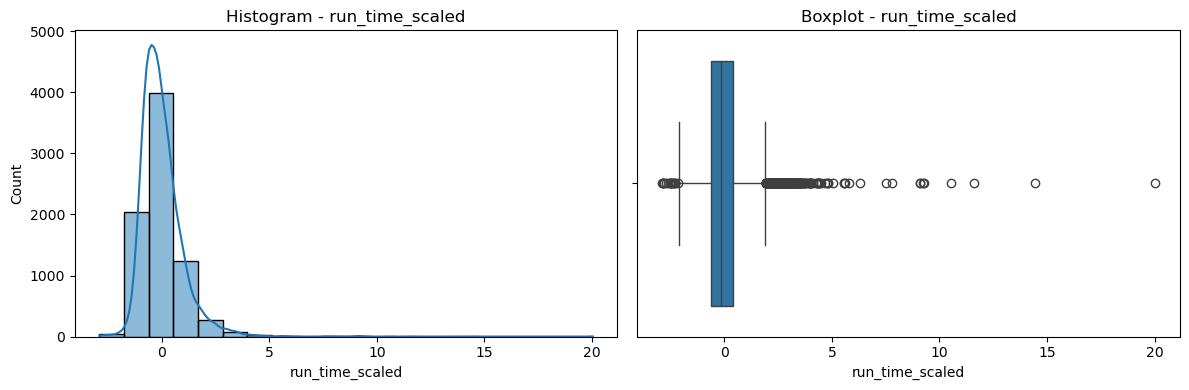

In [63]:
plots_for_processed('run_time_scaled')

Tiếp theo là `release_year`

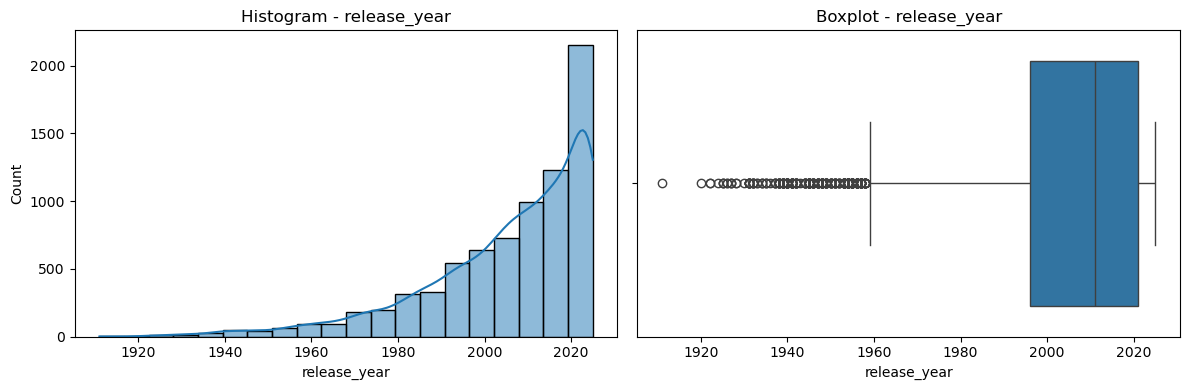

In [61]:
plots_for_processed('release_year')

Với `release_year`:
- Bản chất của dữ liệu này là một đại lượng có tiến trình tuyến tính (Ví dụ như phim năm 2024 có vẻ mới hơn phim năm 1924 một khoảng cách cố định). Vì vậy có thể dùng Min-Max Scaling để đưa về khoảng $[0, 1]$ giúp mô hình học máy dễ dàng học được xu hướng: "Càng gần giá trị 1 thì phim càng hiện đại" và tránh việc con số "2024" quá lớn làm áp đảo các trọng số khác trong mô hình mà vẫn giữ nguyên được thứ tự thời gian.  
- Dù vậy, quan sát biểu đồ thì phân phối năm phát hành thường bị lệch trái (Left-skewed) nghiêm trọng khi số lượng phim cực lớn tập trung ở những năm gần đây (2010–2025) và thưa dần khi quay về quá khứ (những năm 1920–1950). Nếu chỉ dùng Min-Max Scaling, khoảng cách giữa các phim cũ (ví dụ 1930 và 1940) sẽ bị nén lại rất nhỏ so với mật độ dày đặc của phim hiện đại, khiến mô hình khó nhận diện được giá trị của tuổi đời 1 bộ phim.
- Nhóm quyết định sẽ áp dụng Feature Engineering bằng cách tính "tuổi của phim" để tạo đặc trưng mới là `movie_age` bằng cách chuyển nó thành số năm tính từ lúc phát hành đến hiện tại. Lý do là vì các con số "10 năm tuổi" hay "50 năm tuổi" thường mang ý nghĩa tác động trực tiếp hơn đến tâm lý người xem và điểm `rating` hơn là con số năm tuyệt đối.
- Sau đó mới tiến hành áp dụng Log Transformation lên `movie_age` vì tuổi phim cũng sẽ bị lệch, rồi cuối cùng Min-Max Scaling về $[0, 1]$ để đồng bộ giá trị với `metascore`

In [62]:
X_train['movie_age'] = 2026 - X_train['release_year']
X_test['movie_age'] = 2026 - X_test['release_year']

X_train['age_log'] = np.log1p(X_train['movie_age'])
X_test['age_log'] = np.log1p(X_test['movie_age'])

mm_scaler = MinMaxScaler()
X_train['age_scaled'] = mm_scaler.fit_transform(X_train[['age_log']])
X_test['age_scaled'] = mm_scaler.transform(X_test[['age_log']])

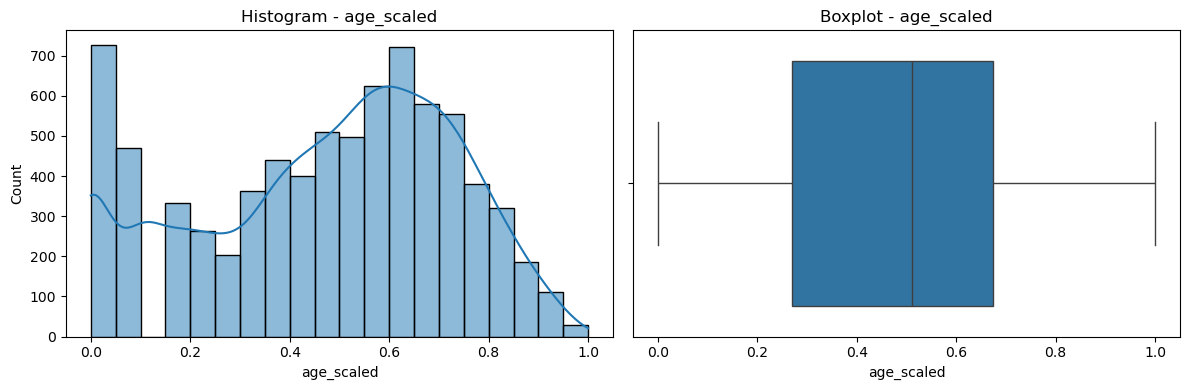

In [64]:
plots_for_processed('age_scaled')

#### Nhóm dữ liệu phân loại

Sau khi Label Encoding cho `mpa` và `genres` để tạo Imputer, chiến lược này có một nhược điểm lớn là nó vô tình tạo ra một thứ tự giả (ví dụ: Action=1, Comedy=2, Drama=3 thì mô hình có thể hiểu Drama > Action, hoặc trung bình của Action và Drama là Comedy). Điều này gây hại cho các mô hình như Linear Regression, SVM hay Neural Networks. Vậy nên nhóm có 1 số chiến lược xử lí khác cho 2 cột dữ liệu này.

Đối với cột `mpa` thì chuyển từ Label Encoding sang Ordinal Encoding (Mã hóa thứ bậc). Bởi vì `mpa` là dữ liệu có thứ tự tự nhiên về mức độ "nhạy cảm" của nội dung (G < PG < PG-13 < R < NC-17). Label Encoding gán số ngẫu nhiên theo bảng chữ cái sẽ làm mất thứ tự này.

In [65]:
X_train = pd.get_dummies(X_train, columns=['mpa_encoded'], prefix='mpa')
X_test = pd.get_dummies(X_test, columns=['mpa_encoded'], prefix='mpa')

Đối với cột `genres` thì chuyển từ Label Encoding sang One-Hot Encoding. Bởi vì thể loại phim là dữ liệu định danh (Nominal), không có thứ tự. Việc dùng số 1, 2, 3 cho Action, Drama, Horror là không chính xác về mặt toán học. Và ở đây, việc dùng One-Hot Encoding sẽ tạo ra các cột riêng biệt (Genre_Action, Genre_Drama...) với giá trị 0 hoặc 1.

In [66]:
X_train = pd.get_dummies(X_train, columns=['genres_encoded'], prefix='genre')
X_test = pd.get_dummies(X_test, columns=['genres_encoded'], prefix='genre')

# Đảm bảo tập Train và Test có cùng số cột sau khi One-Hot
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

Nhìn chung, ở 2 cột dữ liệu này, quy trình xử lí sẽ là Label Encoding $\rightarrow$ Imputer $\rightarrow$ One-Hot/Ordinal.
- Ở giai đoạn Imputer, chúng ta cần dữ liệu dạng số để IterativeImputer (dùng RandomForest) hoạt động. Label Encoding là đủ tốt để Imputer hiểu được mối tương quan giữa các hàng dữ liệu để điền budget hay metascore.
- Còn ở giai đoạn mô hình cuối (Predict Rating), lúc này ta cần độ chính xác cao nhất về mặt ý nghĩa dữ liệu, và Ordinal hay One-Hot Encoding giúp mô hình không bị nhầm lẫn về giá trị của các thể loại.

### Load dữ liệu sau khi tiền xử lí

Quan sát trên tất cả cột dữ liệu, các cột phù hợp nhất để đưa vào mô hình học máy bao gồm:
- Nhóm đã Scale: `budget_scaled`, `vote_count_scaled`, `metascore_minmax`, `run_time_scaled`, `age_scaled`.
- Nhóm One-Hot cho `mpa`: Các cột từ `mpa_0` đến `mpa_22`.
- Nhóm One-Hot cho `genre`: Các cột từ `genre_0` đến `genre_16`.

In [68]:
X_train.columns

Index(['title', 'budget', 'metascore', 'mpa', 'vote_count', 'run_time',
       'release_year', 'genres', 'primary_genres', 'budget_log',
       'vote_count_log', 'budget_scaled', 'vote_count_scaled',
       'metascore_minmax', 'run_time_scaled', 'movie_age', 'age_log',
       'age_scaled', 'mpa_0', 'mpa_1', 'mpa_2', 'mpa_3', 'mpa_4', 'mpa_5',
       'mpa_6', 'mpa_7', 'mpa_8', 'mpa_9', 'mpa_10', 'mpa_11', 'mpa_12',
       'mpa_13', 'mpa_14', 'mpa_15', 'mpa_16', 'mpa_17', 'mpa_18', 'mpa_19',
       'mpa_20', 'mpa_21', 'mpa_22', 'genre_0', 'genre_1', 'genre_2',
       'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8',
       'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14',
       'genre_15', 'genre_16'],
      dtype='object')

In [69]:
X_test.columns

Index(['title', 'budget', 'metascore', 'mpa', 'vote_count', 'run_time',
       'release_year', 'genres', 'primary_genres', 'budget_log',
       'vote_count_log', 'budget_scaled', 'vote_count_scaled',
       'metascore_minmax', 'run_time_scaled', 'movie_age', 'age_log',
       'age_scaled', 'mpa_0', 'mpa_1', 'mpa_2', 'mpa_3', 'mpa_4', 'mpa_5',
       'mpa_6', 'mpa_7', 'mpa_8', 'mpa_9', 'mpa_10', 'mpa_11', 'mpa_12',
       'mpa_13', 'mpa_14', 'mpa_15', 'mpa_16', 'mpa_17', 'mpa_18', 'mpa_19',
       'mpa_20', 'mpa_21', 'mpa_22', 'genre_0', 'genre_1', 'genre_2',
       'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8',
       'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14',
       'genre_15', 'genre_16'],
      dtype='object')

Tổng hợp lại tất cả đặc trưng cuối cùng

In [73]:
mpa_features = [col for col in X_train.columns if col.startswith('mpa_')]
genre_features = [col for col in X_train.columns if col.startswith('genre_')]

final_features = [
    'budget_scaled', 
    'vote_count_scaled', 
    'metascore_minmax', 
    'run_time_scaled', 
    'age_scaled'
] + mpa_features + genre_features

Tạo DataFrame chứa các đặc trưng này, kết hợp với biến mục tiêu để lưu thành file dữ liệu đã xử lí hoàn chỉnh.

In [74]:
X_train_processed = X_train[final_features].copy()
X_test_processed = X_test[final_features].copy()

train_final = pd.concat([X_train_processed, y_train.reset_index(drop=True)], axis=1)
test_final = pd.concat([X_test_processed, y_test.reset_index(drop=True)], axis=1)

Tạo thư mục processed rồi lưu dữ liệu trong thư mục này

In [76]:
output_path = '../data/processed'
if not os.path.exists(output_path):
    os.makedirs(output_path)

train_final.to_csv(f'{output_path}/train_processed.csv', index=False)
test_final.to_csv(f'{output_path}/test_processed.csv', index=False)

print(f"Data successfully saved to {output_path}")
print(f"Number of features used: {len(final_features)}")

Data successfully saved to ../data/processed
Number of features used: 45
